In [140]:
#pip install spotipy --upgrade              # Uncomment this and run it if you haven't installed spotipy before


In [1]:
# Dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
import re, glob
import os, sys
from scipy import stats

import spotipy                          # Set up a config file with ckey and skey. These are available if you go
from spotipy.oauth2 import SpotifyClientCredentials      # to https://developer.spotify.com/, click on Dashboard 
                                        # from the horizontal black menu, login with your normal user info. Click 
# Import Keys                           # on "create an app" if you haven't yet, it doesn't matter what you call it.
from config import clientID, clientSEC           # Then click into
                                        # your project and you should see Client ID and Client Secret. Those are your 
                                        # ckey and skey. 

In [2]:
# Setting up Spotify API info

client_credentials_manager = SpotifyClientCredentials(client_id=clientID, client_secret=clientSEC)

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)



TIP: This next section assumes that you have already downloaded the csv files with the Top200 charts for the country you are working on:

1. Create a subfolder in the folder this notebook is located in called "input_files". Add the owid-covid-data.csv file there, you'll need that later. Then make another subfolder inside input_files called "spotify_top200_charts". Save the csv files you download there. 
2. Go to https://spotifycharts.com
2. Choose the country you want to work on. 
3. Download Weekly Top200 charts for 2019 and 2020, 1 chart per month. We agreed as a group to download the chart from last week of each month, to keep things consistent. Save them in the "spotify_top200_charts" folder you set up. 

In [3]:
# Create dataframe from weekly chart data


path = r"input_files/spotify_top200_charts/*.csv"                # The path requires "".csv" at end of file name. 
                                                                 # This is to prevent the program from blowing up
                                                                 # when it hits some kind of hidden file. 

country_tracks_df = pd.read_csv(glob.glob(path)[0], header=1)    # Sets up **main dataframe** with data from **FIRST** file
string = str(glob.glob(path)[0])                                 # in the folder.
year_month, = re.findall(r"ly-(\d\d\d\d)-(\d\d)-\d\d", string)   # This line extracts the year and month from the 
                                                                 # **file name**
country_tracks_df[['Year']] = year_month[0]
country_tracks_df[['Month']] = year_month[1]
country_tracks_df[['yyyy-mm']] = str(year_month[0]) + "-" + str(year_month[1]) 
Tot_Streams1 = country_tracks_df['Streams'].sum()                # Find out total streams in FIRST file in folder.
country_tracks_df[['Stream %']] = country_tracks_df['Streams'] / Tot_Streams1    # New column with % of streams

for file in glob.glob(path)[1:]:                                 # Now that you have the dataframe set up from the 
        temp_df = pd.read_csv(file, header=1)                    # first file in the folder, this iterates through 
        string = str(file)                                       # remaining files
        year_month, = re.findall(r"ly-(\d\d\d\d)-(\d\d)-\d\d", string)
        #print (year_month)
        Tot_Streams2 = temp_df['Streams'].sum()
        temp_df[['Year']] = year_month[0]
        temp_df[['Month']] = year_month[1]
        temp_df[['yyyy-mm']] = str(year_month[0]) + "-" + str(year_month[1])
        temp_df[['Stream %']] = temp_df['Streams'] / Tot_Streams2
        country_tracks_df = pd.concat([country_tracks_df,        # Adds temperary datafame to end of main dataframe
                                       temp_df])                 # as new rows.  ¿¿¿???? 
        

                                                 
country_tracks_df = country_tracks_df.sort_values(['Year','Month'])  # Sort the new dataframe by year and month




                                                                 # You should get 4,800 rows (24 months x 200 
                                                                 # tracks per month)
country_tracks_df

,Position,Track Name,Artist,Streams,URL,Year,Month,yyyy-mm,Stream %
0,1,MIDDLE CHILD,J. Cole,20663232,https://open.spotify.com/track/2JvzF1RMd7lE3Km...,2019,01,2019-01,0.033351
1,2,7 rings,Ariana Grande,20288575,https://open.spotify.com/track/14msK75pk3pA33p...,2019,01,2019-01,0.032746
2,3,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,13134644,https://open.spotify.com/track/3KkXRkHbMCARz0a...,2019,01,2019-01,0.021199
3,4,Wow.,Post Malone,12578954,https://open.spotify.com/track/6MWtB6iiXyIwun0...,2019,01,2019-01,0.020303
4,5,Going Bad (feat. Drake),Meek Mill,9707256,https://open.spotify.com/track/2IRZnDFmlqMuOrY...,2019,01,2019-01,0.015668
...,...,...,...,...,...,...,...,...,...
195,196,evermore (feat. Bon Iver),Taylor Swift,1581683,https://open.spotify.com/track/0AaV4MJrgmLV3Xh...,2020,12,2020-12,0.003181
196,197,Intentions (feat. Quavo),Justin Bieber,1581498,https://open.spotify.com/track/4umIPjkehX1r7uh...,2020,12,2020-12,0.003180
197,198,Beautiful Crazy,Luke Combs,1581158,https://open.spotify.com/track/2rxQMGVafnNaRaX...,2020,12,2020-12,0.003179
198,199,Party Girl,StaySolidRocky,1580003,https://open.spotify.com/track/3IJYUaN3tx04S4T...,2020,12,2020-12,0.003177


In [4]:
# Get Track IDs
track_names = country_tracks_df['Track Name'].to_list()           # Set up list of tracks to iterate through         
track_ids = []                                                    # Empty list to record track IDs into

for track in track_names:                                         # Heads up: with 4800 tracks to process, this takes
    song_results = sp.search(q=track, type='track', limit=1)      # awhile 
    try:
        track_ids.append(song_results['tracks']['items'][0]['id']) # Prevents program from blowing up - few tracks
        print (f"{track} song ID : {song_results['tracks']['items'][0]['id']}")   # Just to let you know it's working
    except IndexError:                                             # lack track ids
        track_ids.append(np.nan)                                   # nan if nothing

MIDDLE CHILD song ID : 2JvzF1RMd7lE3KmFlsyZD8
7 rings song ID : 6ocbgoVGwYJhOv1GgI9NsF
Sunflower - Spider-Man: Into the Spider-Verse song ID : 3KkXRkHbMCARz0aVfEt68P
Wow. song ID : 7xQAfvXzm3AkraOtGPWIZg
Going Bad (feat. Drake) song ID : 2IRZnDFmlqMuOrYOLnZZyc
Drip Too Hard (Lil Baby & Gunna) song ID : 78QR3Wp35dqAhFEc2qAGjE
Without Me song ID : 7lQ8MOhq6IN2w8EYcFNSUk
SICKO MODE song ID : 2xLMifQCjDGFmkHkpNLD9h
Look Back at It song ID : 3Ol2xnObFdKV9pmRD2t9x8
thank u, next song ID : 3e9HZxeyfWwjeyPAMmWSSQ
ZEZE (feat. Travis Scott & Offset) song ID : 0FZ4Dmg8jJJAPJnvBIzD9z
Dancing With A Stranger (with Normani) song ID : 6Qs4SXO9dwPj5GKvVOv8Ki
Mo Bamba song ID : 1xzBco0xcoJEDXktl7Jxrr
a lot song ID : 2t8yVaLvJ0RenpXUIAC52d
Leave Me Alone song ID : 6V7g6qM8wheMivMWrzbPTM
Saturday Nights song ID : 5kfNriitmkNE8mUbZ7gbq8
Wake Up in the Sky song ID : 0QIjsbm2fh1cJ45XO9eGqq
Keanu Reeves song ID : 3PYx9Wte3jwb48V0wArMOy
SAD! song ID : 3ee8Jmje8o58CHK66QrVC2
Lucid Dreams song ID : 285pBltuF7vW

Wasted (feat. Lil Uzi Vert) song ID : 1a7WZZZH7LzyvorhpOJFTe
REEL IT IN song ID : 5qHirGR7M9tdm6C17DlzSY
can't leave without it song ID : 0hPLZrnDgtKxrym1BHjDhd
Thunder song ID : 1zB4vmk8tFRmM9UULNzbLB
Uproar song ID : 3wScL5W8H40zzCKN0atfBk
Harmony Hall song ID : 39exKIvycQDgs4T6uXdyu0
Nowadays (feat. Landon Cube) song ID : 2u7mxWSeoqTXndK5e08jMp
OTW song ID : 6Hgh47WXVKtXN5zGOu0hjI
Say You Won't Let Go song ID : 5uCax9HTNlzGybIStD3vDh
Don't Come Out The House (with 21 Savage) song ID : 2Grb4G6t9VIqo6moKUloom
comethru song ID : 18uwL0vNUanqZH0ro2QcOP
the remedy for a broken heart (why am I so in love) song ID : 4UKCKdYiLN6IMA5ZESUTL7
NI BIEN NI MAL song ID : 278kSqsZIiYp8p3QjYAqa8
Te Boté - Remix song ID : 3V8UKqhEK5zBkBb6d6ub8i
I'm a Mess song ID : 04ZTP5KsCypmtCmQg5tH9R
Beautiful Crazy song ID : 2rxQMGVafnNaRaXlRMWPde
Body (feat. brando) song ID : 0BrDfbNc3HiIHPGfTT8DRc
Let You Down song ID : 52okn5MNA47tk87PeZJLEL
Call Out My Name song ID : 09mEdoA6zrmBPgTEN5qXmN
So Close song ID :

One Call song ID : 7soJgKhQTO8hLP2JPRkL5O
whoa (mind in awe) song ID : 7pdF27mSDuPWhppnHAmWHa
No Role Modelz song ID : 62vpWI1CHwFy7tMIcSStl8
Beautiful Crazy song ID : 2rxQMGVafnNaRaXlRMWPde
Congratulations song ID : 3a1lNhkSLSkpJE4MSHpDu9
XO Tour Llif3 song ID : 7GX5flRQZVHRAGd6B4TmDO
365 song ID : 2XWjPtKdi5sucFYtVav07d
BAD! song ID : 43CIWpJaJHRcI4mUSjqgc2
ocean eyes song ID : 7hDVYcQq6MxkdJGweuCtl9
KIKA song ID : 6VRwEqn7BvsN0dChfDrMAf
First Off (feat. Travis Scott) song ID : 3WRIaWsws011vHMd9uzPjG
bellyache song ID : 51NFxnQvaosfDDutk0tams
Walk Me Home song ID : 6jfEZdUJ2Yla6h7gTJgKuo
Always Remember Us This Way song ID : 2rbDhOo9Fh61Bbu23T2qCk
Sauce! song ID : 1uL78kFWxhz3umTMWJu8n5
Meant to Be (feat. Florida Georgia Line) song ID : 7iDa6hUg2VgEL1o1HjmfBn
Never Recover (Lil Baby & Gunna, Drake) song ID : 6wWaVoUOzLQJHd3bWAUpdZ
Girls Like You (feat. Cardi B) song ID : 6V1bu6o1Yo5ZXnsCJU8Ovk
goosebumps song ID : 6gBFPUFcJLzWGx4lenP6h2
monster song ID : 2UREu1Y8CO4jXkbvqAtP7g
Wit It

Startender (feat. Offset and Tyga) song ID : 0jAfdqv18goRTUxm3ilRjb
Undrunk song ID : 1Pj5oOFzLYELyyeh1IYRK0
Taste (feat. Offset) song ID : 5IaHrVsrferBYDm0bDyABy
Calling My Spirit song ID : 2MShy1GSSgbmGUxADNIao5
Beautiful Crazy song ID : 2rxQMGVafnNaRaXlRMWPde
I Like It song ID : 58q2HKrzhC3ozto2nDdN4z
Psycho (feat. Ty Dolla $ign) song ID : 3swc6WTsr7rl9DqQKQA55C
Yes Indeed song ID : 6vN77lE9LK6HP2DewaN6HZ
All Girls Are The Same song ID : 4VXIryQMWpIdGgYR4TrjT1
I Fall Apart song ID : 75ZvA4QfFiZvzhj2xkaWAh
Noticed song ID : 7zLYKWcXnYeHHWidalz7rj
Freaky song ID : 10Igtw8bSDyyFs7KIsKngZ
Who Do You Love song ID : 2fVHrSxsQbJUuj9MW9zG1e
Act Up song ID : 3A2yGHWIzmGEIolwonU69h
Ric Flair Drip (& Metro Boomin) song ID : 7sO5G9EABYOXQKNPNiE9NR
Youngblood song ID : 2iUXsYOEPhVqEBwsqP70rE
Patience song ID : 5J5CpT6bgE6KYKk23jgp9W
SLOW DANCING IN THE DARK song ID : 0rKtyWc8bvkriBthvHKY8d
Close To Me (with Diplo) (feat. Swae Lee) song ID : 5JEx7HbmvHQQswJCsoo9rA
Baila Baila Baila song ID : 7mWF

Lucid Dreams song ID : 285pBltuF7vW8TeWk8hdRR
all the good girls go to hell song ID : 6IRdLKIyS4p7XNiP8r6rsx
Outta My Head (with John Mayer) song ID : 09oZ9eXQ2fo6YDrPzJqAoP
Saturday Nights song ID : 5kfNriitmkNE8mUbZ7gbq8
Eastside (with Halsey & Khalid) song ID : 0d2iYfpKoM0QCKvcLCkBao
Here With Me song ID : 5icOoE6VgqFKohjWWNp0Ac
Thotiana song ID : 5GBuCHuPKx6UC7VsSPK0t3
Better Now song ID : 7dt6x5M1jzdTEt8oCbisTK
Shallow song ID : 2VxeLyX666F8uXCJ0dZF8B
Suge song ID : 2gwkD6igEhQbDQegRCcdoB
That's a Rack song ID : 4pCEIQ6wBVuaJdER5bALtO
Paradise song ID : 0Rx0DJI556Ix5gBny6EWmn
Let Me Down Slowly song ID : 2qxmye6gAegTMjLKEBoR3d
Mo Bamba song ID : 1xzBco0xcoJEDXktl7Jxrr
I song ID : 2kJwzbxV2ppxnQoYw4GLBZ
SAD! song ID : 3ee8Jmje8o58CHK66QrVC2
Kill This Love song ID : 6hvczQ05jc1yGlp9zhb95V
Dancing With A Stranger (with Normani) song ID : 6Qs4SXO9dwPj5GKvVOv8Ki
Racks in the Middle (feat. Roddy Ricch and Hit-Boy) song ID : 6ya8ejoKgw906Y8LWclqrp
ZEZE (feat. Travis Scott & Offset) song 

Old Town Road (feat. Billy Ray Cyrus) - Remix song ID : 6zpiwiexX8HpFCZLyIWKDv
bad guy song ID : 2Fxmhks0bxGSBdJ92vM42m
I Don't Care (with Justin Bieber) song ID : 3HVWdVOQ0ZA45FuZGSfvns
Truth Hurts song ID : 3HWzoMvoF3TQfYg4UPszDq
Suge song ID : 2gwkD6igEhQbDQegRCcdoB
Sunflower - Spider-Man: Into the Spider-Verse song ID : 3KkXRkHbMCARz0aVfEt68P
Pop Out (feat. Lil Tjay) song ID : 6uFn47ACjqYkc0jADwEdj1
If I Can't Have You song ID : 6LsAAHotRLMOHfCsSfYCsz
Cross Me (feat. Chance the Rapper & PnB Rock) song ID : 543bCW2ruMPmxUBWirQ3MR
Talk (feat. Disclosure) song ID : 6TqXcAFInzjp0bODyvrWEq
MIDDLE CHILD song ID : 2JvzF1RMd7lE3KmFlsyZD8
Isis song ID : 4h7qcXBtaOJnmrapxoWxGf
Old Town Road song ID : 2YpeDb67231RjR0MgVLzsG
Wow. song ID : 7xQAfvXzm3AkraOtGPWIZg
Go Loko (feat. Tyga, Jon Z) song ID : 1kK6DwzyXJSp58u5HYWwuD
Sanguine Paradise song ID : 3XiNC94b4Tq1xwv70sQJGN
Swervin (feat. 6ix9ine) song ID : 1wJRveJZLSb1rjhnUHQiv6
Sucker song ID : 22vgEDb5hykfaTwLuskFGD
Nightmare song ID : 340UVh

Love Ain't song ID : 6uVzeU47Qzg0rrMneP5BNg
The Middle song ID : 6GG73Jik4jUlQCkKg9JuGO
Nights Like This (feat. Ty Dolla $ign) song ID : 6ZRuF2n1CQxyxxAAWsKJOy
ARE WE STILL FRIENDS? song ID : 5TxRUOsGeWeRl3xOML59Ai
HUMBLE. song ID : 7KXjTSCq5nL1LoYtL7XAwS
Rumor song ID : 56eGOeSsqdg3FLxdo83TwV
Space Cadet (feat. Gunna) song ID : 1fewSx2d5KIZ04wsooEBOz
MIDDLE CHILD song ID : 2JvzF1RMd7lE3KmFlsyZD8
goosebumps song ID : 6gBFPUFcJLzWGx4lenP6h2
She Got the Best of Me song ID : 698eQRku24PIYPQPHItKlA
changes song ID : 7AFASza1mXqntmGtbxXprO
Let Me Down Slowly song ID : 2qxmye6gAegTMjLKEBoR3d
Kill This Love song ID : 6hvczQ05jc1yGlp9zhb95V
Look What God Gave Her song ID : 2KqJC0koTBUyDlsMt5ok1V
Pure Cocaine song ID : 577YBGuskWkVDCxZrLRB4v
Nice For What song ID : 3CA9pLiwRIGtUBiMjbZmRw
I DON'T LOVE YOU ANYMORE song ID : 5A0M6B0RBSXSNWv0wcppZ9
Talk You Out Of It song ID : 4qQwGRtGT7l6ckQtdPEFd4
Look Alive (feat. Drake) song ID : 4qKcDkK6siZ7Jp1Jb4m0aL
Mine song ID : 7uzmGiiJyRfuViKKK3lVmR
Girl

Speechless song ID : 3GJ4hzg4lrGwU51Y3VARbF
Nightmare song ID : 340UVheS8z3ncW9TTUhAbc
Youngblood song ID : 2iUXsYOEPhVqEBwsqP70rE
I Fall Apart song ID : 75ZvA4QfFiZvzhj2xkaWAh
Mo Bamba song ID : 1xzBco0xcoJEDXktl7Jxrr
Stripper Bowl song ID : 7mv4eldXEFbf3s3ZEfbmlC
ocean eyes song ID : 7hDVYcQq6MxkdJGweuCtl9
Mad Love song ID : 4usK3z2OdvsKtKS9YuleaR
Rumor song ID : 56eGOeSsqdg3FLxdo83TwV
Fuck Love (feat. Trippie Redd) song ID : 7AQim7LbvFVZJE3O8TYgf2
Leave Me Alone song ID : 6V7g6qM8wheMivMWrzbPTM
God's Plan song ID : 6DCZcSspjsKoFjzjrWoCdn
Good As Hell song ID : 6KgBpzTuTRPebChN0VTyzV
Here With Me song ID : 5icOoE6VgqFKohjWWNp0Ac
All Girls Are The Same song ID : 4VXIryQMWpIdGgYR4TrjT1
She Got the Best of Me song ID : 698eQRku24PIYPQPHItKlA
i love you song ID : 6CcJMwBtXByIz4zQLzFkKc
SOS (feat. Aloe Blacc) song ID : 2x0RZdkZcD8QRI53XT4GI5
I Like Me Better song ID : 2P91MQbaiQOfbiz9VqhqKQ
Young Dumb & Broke song ID : 5Z3GHaZ6ec9bsiI5BenrbY
XO Tour Llif3 song ID : 7GX5flRQZVHRAGd6B4TmDO


My Type song ID : 5KBARWIxeMGkvUax9VtVC9
Better Now song ID : 7dt6x5M1jzdTEt8oCbisTK
Old Town Road song ID : 2YpeDb67231RjR0MgVLzsG
Only Human song ID : 0DiDStADDVh3SvAsoJAFMk
Summer Days (feat. Macklemore & Patrick Stump of Fall Out Boy) song ID : 7Feaw9WAEREY0DUOSXJLOM
Time - Edit song ID : 68Vm2W4oURsPV3121vUZgB
rockstar (feat. 21 Savage) song ID : 0e7ipj03S05BNilyu5bRzt
La La Land (feat. YG) song ID : 4oM9DGUTrRaXJDypxxHztZ
gone girl song ID : 3iH29NcCxYgI5shlkZrUoB
Dancing With A Stranger (with Normani) song ID : 6Qs4SXO9dwPj5GKvVOv8Ki
Without Me song ID : 7lQ8MOhq6IN2w8EYcFNSUk
Under The Sun (with J. Cole & Lute feat. DaBaby) song ID : 6MF4tRr5lU8qok8IKaFOBE
Worth It song ID : 0PQoUlzP7ILdcrzpajHXc0
Look Back at It song ID : 3Ol2xnObFdKV9pmRD2t9x8
SAD! song ID : 3ee8Jmje8o58CHK66QrVC2
ME! (feat. Brendon Urie of Panic! At The Disco) song ID : 2Rk4JlNc2TPmZe2af99d45
Uno song ID : 3AEgic4yp82NxMWUjHtxnO
Soltera - Remix song ID : 1c0hsvHLELX6y8qymnpLKL
Baby Sitter (feat. Offset) song

Daylight song ID : 6Ed1q0X8oSKSm4IIhiQbYg
Hot Girl Summer (feat. Nicki Minaj & Ty Dolla $ign) song ID : 5N1o6d8zGcSZSeMFkOUQOk
Good as Hell song ID : 6KgBpzTuTRPebChN0VTyzV
It’s Nice To Have A Friend song ID : 1SmiQ65iSAbPto6gPFlBYm
Hot (feat. Gunna) song ID : 5Z8HZM6iQMhhqyPcCGY5g9
Pop Out (feat. Lil Tjay) song ID : 6uFn47ACjqYkc0jADwEdj1
Slide Away song ID : 44ADyYoY5liaRa3EOAl4uf
Shotta Flow (Feat. Blueface) [Remix] song ID : 67XyC1GdSkKb9sbRRkUDXS
Ransom (with Juice WRLD) - Remix song ID : 2WsuSYJNXGKXVYkHPnq2yp
Old Town Road - Remix song ID : 2YpeDb67231RjR0MgVLzsG
Love Me song ID : 4e0FYxSROat25pH16zMTZI
Talk (feat. Disclosure) song ID : 6TqXcAFInzjp0bODyvrWEq
Did It Again song ID : 4guBZjUyrGoHsTahO3IHdj
China song ID : 2ksOAxtIxY8yElEWw8RhgK
Baguettes in the Face (feat. NAV, Playboi Carti & A Boogie Wit da Hoodie) song ID : 2zjGJ0dChMR0KxBZS15aqo
I Don't Care (with Justin Bieber) song ID : 3HVWdVOQ0ZA45FuZGSfvns
MIDDLE CHILD song ID : 2JvzF1RMd7lE3KmFlsyZD8
Motivation song ID :

Hey Look Ma, I Made It song ID : 22oEJW6r2rMb9z4IntfyEa
Armed And Dangerous song ID : 5wujBwqG7INdStqGd4tRMX
Best Part (feat. Daniel Caesar) song ID : 4OBZT9EnhYIV17t4pGw7ig
La La Land (feat. YG) song ID : 4oM9DGUTrRaXJDypxxHztZ
Mo Bamba song ID : 1xzBco0xcoJEDXktl7Jxrr
Location song ID : 152lZdxL1OR0ZMW6KquMif
you should see me in a crown song ID : 3XF5xLJHOQQRbWya6hBp7d
God's Plan song ID : 6DCZcSspjsKoFjzjrWoCdn
Circles song ID : 21jGcNKet2qwijlDFuPiPb
Ransom song ID : 1lOe9qE0vR9zwWQAOk6CoO
Saint-Tropez song ID : 05mDaV9Vb3wrzjF6OPZnhq
Goodbyes (Feat. Young Thug) song ID : 0t3ZvGKlmYmVsDzBJAXK8C
Truth Hurts song ID : 3HWzoMvoF3TQfYg4UPszDq
Take What You Want (feat. Ozzy Osbourne & Travis Scott) song ID : 7CZyCXKG6d5ALeq41sLzbw
Enemies (feat. DaBaby) song ID : 0Xek5rqai2jcOWCYWJfVCF
Sunflower - Spider-Man: Into the Spider-Verse song ID : 3KkXRkHbMCARz0aVfEt68P
223's (feat. 9lokknine) song ID : 4sjiIpEv617LDXaidKioOI
Panini song ID : 1000nHvUdawXuUHgBod4Wv
No Guidance (feat. Drake) s

I song ID : 2kJwzbxV2ppxnQoYw4GLBZ
Soltera - Remix song ID : 1c0hsvHLELX6y8qymnpLKL
Dancing With A Stranger (with Normani) song ID : 6Qs4SXO9dwPj5GKvVOv8Ki
All Girls Are The Same song ID : 4VXIryQMWpIdGgYR4TrjT1
Tequila song ID : 42fw0rxRO2xbesF6mJfd4Y
Faucet Failure song ID : 1ThmUihH9dF8EV08ku5AXN
Yes Indeed song ID : 6vN77lE9LK6HP2DewaN6HZ
bury a friend song ID : 4SSnFejRGlZikf02HLewEF
Hate Me (with Juice WRLD) song ID : 6kls8cSlUyHW2BUOkDJIZE
Saturday Nights song ID : 5kfNriitmkNE8mUbZ7gbq8
Youngblood song ID : 2iUXsYOEPhVqEBwsqP70rE
Beer Never Broke My Heart song ID : 7aEtlGHoiPAfRB084NiDmx
Act Up song ID : 3A2yGHWIzmGEIolwonU69h
Rodeo song ID : 4ak7xjvBeBOcJGWFDX9w5n
High Hopes song ID : 1rqqCSm0Qe4I9rUvWncaom
I Like Me Better song ID : 2P91MQbaiQOfbiz9VqhqKQ
Yo x Ti, Tu x Mi song ID : 7BlBVFwvbWvcwNcUarQmjk
Only Human song ID : 0DiDStADDVh3SvAsoJAFMk
Congratulations song ID : 3a1lNhkSLSkpJE4MSHpDu9
Shallow song ID : 2VxeLyX666F8uXCJ0dZF8B
Fuck Love (feat. Trippie Redd) song ID :

Callaita song ID : 2TH65lNHgvLxCKXM3apjxI
Writing on the Wall (feat. Post Malone & Cardi B) song ID : 7x9nXsowok1JszkVztI5NI
LA CANCIÓN song ID : 0fea68AdmYNygeTGI4RC18
BEST ON EARTH (feat. BIA) - Bonus song ID : 0xKBkLcF71uUQeTA7FSu4A
Bruises song ID : 4Of7rzpRpV1mWRbhp5rAqG
Cash Shit (feat. DaBaby) song ID : 2rMAtCaTj16NptyVfEIeAC
rockstar (feat. 21 Savage) song ID : 0e7ipj03S05BNilyu5bRzt
Baguettes in the Face (feat. NAV, Playboi Carti & A Boogie Wit da Hoodie) song ID : 2zjGJ0dChMR0KxBZS15aqo
7 rings song ID : 6ocbgoVGwYJhOv1GgI9NsF
INTRO song ID : 5VfEuwErhx6X4eaPbyBfyu
My Type song ID : 5KBARWIxeMGkvUax9VtVC9
Happier song ID : 2dpaYNEQHiRxtZbfNsse99
You Need To Calm Down song ID : 6RRNNciQGZEXnqk8SQ9yv5
Envy Me song ID : 7rvyVWja33WG9R97oeJAjx
Better song ID : 6gdLyYNuhWBzqwlOFSsXC7
Feelings song ID : 0s26En1JoJhVj32vizElpA
I Fall Apart song ID : 75ZvA4QfFiZvzhj2xkaWAh
goosebumps song ID : 6gBFPUFcJLzWGx4lenP6h2
boyfriend (with Social House) song ID : 0Ryd8975WihbObpp5cPW1t
Pure 

Suicidal song ID : 1iSqfoUFnQwV0QW1EfUit8
Pop Out (feat. Lil Tjay) song ID : 6uFn47ACjqYkc0jADwEdj1
Santa Tell Me song ID : 0lizgQ7Qw35od7CYaoMBZb
Jingle Bell Rock song ID : 7vQbuQcyTflfCIOu3Uzzya
Murder On My Mind song ID : 7eBqSVxrzQZtK2mmgRG6lC
Mean It song ID : 3uc8AGNL0KbvISIrjnfRvN
Lucid Dreams song ID : 285pBltuF7vW8TeWk8hdRR
Lalala song ID : 51Fjme0JiitpyXKuyQiCDo
Bad Bad Bad (feat. Lil Baby) song ID : 1GeNui6m825V8jP4uKiIaH
Juicy song ID : 7f5trao56t7sB7f14QDTmp
Hate Me (with Juice WRLD) song ID : 6kls8cSlUyHW2BUOkDJIZE
when the party's over song ID : 43zdsphuZLzwA9k4DJhU0I
Reply (feat. Lil Uzi Vert) song ID : 1njRzdfGNUY2RZU0lVO787
Somebody song ID : 4wCmqSrbyCgxEXROQE6vtV
It's the Most Wonderful Time of the Year song ID : 5hslUAKq9I9CG2bAulFkHN
Drip Too Hard (Lil Baby & Gunna) song ID : 78QR3Wp35dqAhFEc2qAGjE
Love Sick song ID : 2PRKaIkl62537yLUt8VhHR
lovely (with Khalid) song ID : 0u2P5u6lvoDfwTYjAADbn4
Last Christmas song ID : 2FRnf9qhLbvw8fu4IBXx78
SICKO MODE song ID : 2x

White Christmas song ID : 4so0Wek9Ig1p6CRCHuINwW
Feliz Navidad song ID : 0oPdaY4dXtc3ZsaG17V972
Mistletoe song ID : 7xapw9Oy21WpfEcib2ErSA
Watermelon Sugar song ID : 6UelLqGlWMcVH1E5c4H7lY
Ballin' (with Roddy Ricch) song ID : 3QzAOrNlsabgbMwlZt7TAY
Christmas (Baby Please Come Home) song ID : 3PIDciSFdrQxSQSihim3hN
Wonderful Christmastime [Edited Version] - Remastered 2011 / Edited Version song ID : 1SV1fxF65n9NhRHp3KlBuu
Lucid Dreams song ID : 285pBltuF7vW8TeWk8hdRR
Blinding Lights song ID : 0VjIjW4GlUZAMYd2vXMi3b
Happy Xmas (War Is Over) - Remastered 2010 song ID : 27RYrbL6S02LNVhDWVl38b
Heartless song ID : 4EWCNWgDS8707fNSZ1oaA5
Do They Know It's Christmas? - 1984 Version song ID : 0247StOpd3AkeBQzANX4Zf
Blue Christmas song ID : 3QiAAp20rPC3dcAtKtMaqQ
My Oh My (feat. DaBaby) song ID : 3yOlyBJuViE2YSGn3nVE1K
It's Beginning to Look a Lot Like Christmas (with Mitchell Ayres & His Orchestra) song ID : 2pXpURmn6zC5ZYDMms6fwa
Someone You Loved song ID : 7qEHsqek33rTcFNT9PFqLf
Suicidal song

White Christmas (with Shania Twain) song ID : 2gbCG4Rt9984UZ7Tc0dIFd
rockstar (feat. 21 Savage) song ID : 0e7ipj03S05BNilyu5bRzt
Sanguine Paradise song ID : 3XiNC94b4Tq1xwv70sQJGN
How Do You Sleep? song ID : 6b2RcmUt1g9N9mQ3CbjX2Y
ORANGE SODA song ID : 5FkoSXiJPKTNyYgALRJFhD
One More Sleep song ID : 78pn8k7RogKo2oxl0DyX6d
Talk (feat. Disclosure) song ID : 6TqXcAFInzjp0bODyvrWEq
I Fall Apart song ID : 75ZvA4QfFiZvzhj2xkaWAh
ocean eyes song ID : 7hDVYcQq6MxkdJGweuCtl9
She song ID : 698eQRku24PIYPQPHItKlA
RITMO (Bad Boys For Life) song ID : 6cy3ki60hLwimwIje7tALf
Sunflower, Vol. 6 song ID : 6iYMfxznTBlcVOgRHab2W0
Better Now song ID : 7dt6x5M1jzdTEt8oCbisTK
Rudolph The Red-Nosed Reindeer song ID : 3edDztKB6QeGefnIpLJgqr
Writing on the Wall (feat. Post Malone, Cardi B & Rvssian) song ID : 7ntUbTIwmwOD6ygCMRZT6e
Graduation (with Juice WRLD) song ID : 6cjSh516BbrNUs213jDAGm
Cozy Little Christmas song ID : 02FaKXXL7KUtRc7K0k54tL
Hot Shower song ID : 00ko9WaS4jOX1kEk3gvHjf
Make It To Christmas 

Enemies (feat. DaBaby) song ID : 0Xek5rqai2jcOWCYWJfVCF
BEST ON EARTH (feat. BIA) - Bonus song ID : 0xKBkLcF71uUQeTA7FSu4A
Cash Shit (feat. DaBaby) song ID : 2rMAtCaTj16NptyVfEIeAC
One Thing Right song ID : 4hPpVbbakQNv8YTHYaOJP4
all the good girls go to hell song ID : 6IRdLKIyS4p7XNiP8r6rsx
Had Enough (feat. Quavo & Offset) song ID : 7LGWmZaoS7jZJ5tEi9EcDi
wish you were gay song ID : 3Fj47GNK2kUF0uaEDgXLaD
I Don't Care (with Justin Bieber) song ID : 3HVWdVOQ0ZA45FuZGSfvns
Woods song ID : 3Qa944OTMZkg8DHjET8JQv
VALENTINO song ID : 6piAUJJQFD8oHDUr0b7l7q
Sucker song ID : 22vgEDb5hykfaTwLuskFGD
Talk (feat. Disclosure) song ID : 6TqXcAFInzjp0bODyvrWEq
Hot (feat. Gunna) song ID : 5Z8HZM6iQMhhqyPcCGY5g9
Eastside (with Halsey & Khalid) song ID : 0d2iYfpKoM0QCKvcLCkBao
U Played (feat. Lil Baby) song ID : 7qeWNGBqqagdwf4KnjRzGZ
Sanguine Paradise song ID : 3XiNC94b4Tq1xwv70sQJGN
Fuck Love (feat. Trippie Redd) song ID : 7AQim7LbvFVZJE3O8TYgf2
Better Now song ID : 7dt6x5M1jzdTEt8oCbisTK
It's You 

Old Me song ID : 58qO4dGa5SgNdtvqvpewyz
Baby (Lil Baby feat. DaBaby) song ID : 5MPPttjfGap2C6j6eKcO6J
We are Bulletproof : the Eternal song ID : 44WLOqH7QayQOQdeUHeKUK
Lose You To Love Me song ID : 4l0Mvzj72xxOpRrp6h8nHi
Going Bad (feat. Drake) song ID : 2IRZnDFmlqMuOrYOLnZZyc
July song ID : 6J2LdBN97cDWn0MLxYh9HB
Señorita song ID : 0TK2YIli7K1leLovkQiNik
Lottery (Renegade) song ID : 4dZTZbmJBCCofAExHwefda
Murder On My Mind song ID : 7eBqSVxrzQZtK2mmgRG6lC
Friends song ID : 2jQiSYrwJehQAcuaaQrXnS
Inner Child song ID : 4BKOjYosPhw334moS3wlbO
The Way song ID : 2eAZfqOm4EnOF9VvN50Tyc
Physical song ID : 3AzjcOeAmA57TIOr9zF1ZW
Jocelyn Flores song ID : 7m9OqQk4RVRkw9JJdeAw96
Take What You Want (feat. Ozzy Osbourne & Travis Scott) song ID : 7CZyCXKG6d5ALeq41sLzbw
Drip Too Hard (Lil Baby & Gunna) song ID : 78QR3Wp35dqAhFEc2qAGjE
Stuck In A Dream (feat. Gunna) song ID : 7iHHxY2NLlJRAmlAmC4ahQ
What If I Told You That I Love You song ID : 74D7JUfU6HYeMx4bZhsHnG
Pop Out (feat. Lil Tjay) song ID : 

La Difícil song ID : 6NfrH0ANGmgBXyxgV2PeXt
My Oh My (feat. DaBaby) song ID : 3yOlyBJuViE2YSGn3nVE1K
Robbery song ID : 6Hj9jySrnFppAI0sEMCZpJ
Safaera song ID : 2DEZmgHKAvm41k4J3R2E9Y
OUT WEST (feat. Young Thug) song ID : 6gi6y1xwmVszDWkUqab1qw
Bean (Kobe) [feat. Chief Keef] song ID : 0IpnZchq8ek2A6pGEP2Qb1
PTSD song ID : 3jT2LKH0RSbQ8jIUNFzXm5
Silly Watch song ID : 5egD7A5x9AHdVO2fMo3Wbo
10,000 Hours (with Justin Bieber) song ID : 2wrJq5XKLnmhRXHIAf9xBa
Si Veo a Tu Mamá song ID : 41wtwzCZkXwpnakmwJ239F
If the World Was Ending - feat. Julia Michaels song ID : 2kJwzbxV2ppxnQoYw4GLBZ
Moral of the Story song ID : 2nC3QhMI9reBIOWutbU3Tj
Rojo song ID : 2ysP4eGoInpNLEQjJwW3BD
No Idea song ID : 7AzlLxHn24DxjgQX73F9fU
You should be sad song ID : 7lidXGPXPYLNThITAOTlkK
TOES (feat. Lil Baby & Moneybagg Yo) song ID : 2FvD20Z8aoWIePi7PoN8sG
Yessirskiii song ID : 59JWp4PjZ9TRM8cmtaDYB1
Sum 2 Prove song ID : 2jU0zYljI41p442xBMTbX8
Maniac song ID : 6KfoDhO4XUWSbnyKjNp9c4
B.S. (feat. H.E.R.) song ID : 

Walk Em Down (feat. Roddy Ricch) song ID : 4cSSL3YafYjM3yjgFO1vJg
Circles song ID : 21jGcNKet2qwijlDFuPiPb
Sunday Best song ID : 1Cv1YLb4q0RzL6pybtaMLo
Intentions (feat. Quavo) song ID : 4umIPjkehX1r7uhmGvXiSV
Life Is Good (feat. Drake) song ID : 5yY9lUy8nbvjM1Uyo1Uqoc
ROXANNE song ID : 696DnlkuDOXcMAnKlTgXXK
Falling song ID : 1ZMiCix7XSAbfAJlEZWMCp
Supalonely song ID : 4nK5YrxbMGZstTLbvj6Gxw
Adore You song ID : 3jjujdWJ72nww5eGnfs2E7
High Fashion (feat. Mustard) song ID : 07KXEDMj78x68D884wgVEm
After Party song ID : 527k23H0A4Q0UJN3vGs0Da
P2 song ID : 3kW4z2pIj5VY5fLjBrMRL5
Turks (feat. Travis Scott) song ID : 0lSZh5W0wDeurkGzLYY6hf
Myron song ID : 56uXDJRCuoS7abX3SkzHKQ
PTSD song ID : 3jT2LKH0RSbQ8jIUNFzXm5
Ballin' (with Roddy Ricch) song ID : 3QzAOrNlsabgbMwlZt7TAY
Sunflower - Spider-Man: Into the Spider-Verse song ID : 3KkXRkHbMCARz0aVfEt68P
Lucid Dreams song ID : 285pBltuF7vW8TeWk8hdRR
FIND MY WAY song ID : 1gVCEnryJhkdQcuC0Kbvor
Someone You Loved song ID : 7qEHsqek33rTcFNT9PFqLf


Costa Rica song ID : 3tdjTdCCgKtwacsICCtPZZ
Happier song ID : 2dpaYNEQHiRxtZbfNsse99
Hurricane song ID : 6xHI9KjUjYT0FPtGO8Mxa1
Tongue Tied song ID : 0GO8y8jQk1PkHzS31d699N
Sick and Tired song ID : 0DILU9jjSTnCv1dcbUH3ib
Illuminati song ID : 2Ky6OednfOVrxDiKAhCZ7I
ORANGE SODA song ID : 5FkoSXiJPKTNyYgALRJFhD
It's You song ID : 5DqdesEfbRyOlSS3Tf6c29
Nobody But You (Duet with Gwen Stefani) song ID : 5M8goiFYynmNxhueYW6grR
i love you song ID : 6CcJMwBtXByIz4zQLzFkKc
Tusa song ID : 7k4t7uLgtOxPwTpFmtJNTY
Beautiful People (feat. Khalid) song ID : 4evmHXcjt3bTUHD1cvny97
Sucker song ID : 22vgEDb5hykfaTwLuskFGD
Save Your Tears song ID : 5QO79kh1waicV47BqGRL3g
Wait a Minute! song ID : 0y60itmpH0aPKsFiGxmtnh
GOODMORNINGTOKYO! song ID : 0Q2n5yzl2XRqYbV77tZNYp
Vete song ID : 5DxXgozhkPLgrbKFY91w0c
Lose You To Love Me song ID : 4l0Mvzj72xxOpRrp6h8nHi
Sanguine Paradise song ID : 3XiNC94b4Tq1xwv70sQJGN
Lights Up song ID : 4jAIqgrPjKLTY9Gbez25Qb
Congratulations song ID : 3a1lNhkSLSkpJE4MSHpDu9
Yummy 

Numbers (feat. Roddy Ricch, Gunna and London On Da Track) song ID : 733c1CWmIGymoQXdp7Us88
Fuck Love (feat. Trippie Redd) song ID : 7AQim7LbvFVZJE3O8TYgf2
Lo Mein song ID : 6CUP2khYzdphXebxVTfPE3
Falling song ID : 1ZMiCix7XSAbfAJlEZWMCp
Know Your Worth song ID : 0TrPqhAMoaKUFLR7iYDokf
FIND MY WAY song ID : 1gVCEnryJhkdQcuC0Kbvor
VIBEZ song ID : 0fySG6A6qLE8IvDpayb5bM
EARFQUAKE song ID : 5hVghJ4KaYES3BFUATCYn0
JUMP (feat. YoungBoy Never Broke Again) song ID : 0oT9ElXYSxvnOOagP9efDq
No Guidance (feat. Drake) song ID : 6XHVuErjQ4XNm6nDPVCxVX
F.N song ID : 0RLLvYBopDwooCyvnTwgYu
21 song ID : 3JKgcAa7r07ocVWcV8bS0H
Tongue Tied song ID : 0GO8y8jQk1PkHzS31d699N
Señorita song ID : 0TK2YIli7K1leLovkQiNik
When It Rains It Pours song ID : 1mMLMZYXkMueg65jRRWG1l
Tonight (I Wish I Was Your Boy) song ID : 7DmTaJoM7L020qm3egqNsM
bloody valentine song ID : 6mADjHs6FXdroPzEGW6KVJ
Going Bad (feat. Drake) song ID : 2IRZnDFmlqMuOrYOLnZZyc
223's (feat. 9lokknine) song ID : 4sjiIpEv617LDXaidKioOI
GIMMICK so

lovely (with Khalid) song ID : 0u2P5u6lvoDfwTYjAADbn4
Truth Hurts song ID : 3HWzoMvoF3TQfYg4UPszDq
Beautiful Crazy song ID : 2rxQMGVafnNaRaXlRMWPde
Say So (feat. Nicki Minaj) song ID : 11VApNQCWLJdzxWrlmwzUa
Wow. song ID : 7xQAfvXzm3AkraOtGPWIZg
10,000 Hours (with Justin Bieber) song ID : 2wrJq5XKLnmhRXHIAf9xBa
bad guy song ID : 2Fxmhks0bxGSBdJ92vM42m
XO Tour Llif3 song ID : 7GX5flRQZVHRAGd6B4TmDO
Solitaires (feat. Travis Scott) song ID : 4kfeRwpq5KUaqTkgi4TbDF
Heartless (feat. Morgan Wallen) song ID : 3FU6urUVsgXa6RBuV2PdRk
Safaera song ID : 2DEZmgHKAvm41k4J3R2E9Y
rockstar (feat. 21 Savage) song ID : 0e7ipj03S05BNilyu5bRzt
Suge song ID : 2gwkD6igEhQbDQegRCcdoB
Sum 2 Prove song ID : 2jU0zYljI41p442xBMTbX8
Stunnin' (feat. Harm Franklin) song ID : 2JSmxLqt8h7ZpJJkfuLJvK
Woah song ID : 598yNsG1JFrGd4n2kMoz7F
Go Stupid song ID : 4PklAHGXT5ityno3IA8SKd
Goodbyes (feat. Young Thug) song ID : 0t3ZvGKlmYmVsDzBJAXK8C
Memories song ID : 2b8fOow8UzyDFAE27YhOZM
I Fall Apart song ID : 75ZvA4QfFiZvzh

Circles song ID : 21jGcNKet2qwijlDFuPiPb
After Party song ID : 527k23H0A4Q0UJN3vGs0Da
Sunflower - Spider-Man: Into the Spider-Verse song ID : 3KkXRkHbMCARz0aVfEt68P
The Bigger Picture song ID : 44gRhRi2OhEf7moAUj6MD1
Intentions (feat. Quavo) song ID : 4umIPjkehX1r7uhmGvXiSV
Rain On Me (with Ariana Grande) song ID : 24ySl2hOPGCDcxBxFIqWBu
Robbery song ID : 6Hj9jySrnFppAI0sEMCZpJ
Hit My Line song ID : 24FR8mXTaiGZPrxnkf1kcP
Stay High song ID : 21CkzgKCBCq5V4XKjiGSIj
Chicago Freestyle (feat. Giveon) song ID : 4wVOKKEHUJxHCFFNUWDn0B
GP4 song ID : 1OmmCrliFMIWzNke437KHE
Flex (feat. Juice WRLD) song ID : 2QqJTIlGKRLJC3onkavYEz
No Pressure Intro song ID : 41hwbZ1yF705MxJ7H9bwEu
All Girls Are The Same song ID : 4VXIryQMWpIdGgYR4TrjT1
RELENTLESS (feat. Lil Uzi Vert) song ID : 6nDSLDomNqfet6w0r1GHAz
Titanic song ID : 1YM6c2sxbf2Jacl9IFgn4I
Dior song ID : 79s5XnCN4TJKTVMSmOx8Ep
Bad Energy song ID : 7d94IqWX2UmSKMGUYSGFJG
21 song ID : 3JKgcAa7r07ocVWcV8bS0H
Life Is Good (feat. Drake) song ID : 5yY

Heather song ID : 4xqrdfXkTW4T0RauPLv3WA
Blinding Lights song ID : 0VjIjW4GlUZAMYd2vXMi3b
Lemonade song ID : 02kDW379Yfd5PzW5A6vuGt
Blueberry Faygo song ID : 6wJYhPfqk3KGhHRG76WzOh
7 Summers song ID : 4obHzpwGrjoTuZh2DItEMZ
Savage Love (Laxed - Siren Beat) song ID : 1xQ6trAsedVPCdbtDAmk0c
The Woo (feat. 50 Cent & Roddy Ricch) song ID : 1H7KnK26kc1YyellpbINEn
Go Crazy song ID : 1IIKrJVP1C9N7iPtG6eOsK
Roses - Imanbek Remix song ID : 0zLCBJZSiELJf02ucPP9wb
GREECE (feat. Drake) song ID : 35RJhm1pEovTBwnNR0zWad
POPSTAR (feat. Drake) song ID : 6EDO9iiTtwNv6waLwa1UUq
Midnight Sky song ID : 27ycaQnQAxaPiyeg3nr2aB
Party Girl song ID : 5RqR4ZCCKJDcBLIn4sih9l
Tap In song ID : 4Hpib09wXgD84w4uwTPnYD
Conversations song ID : 4K06PO78fW4mnBVenxGNob
Hate The Other Side (with Marshmello & The Kid Laroi) song ID : 0ada5XsQGLPUVbmTCkAP49
The Box song ID : 0nbXyq5TXYPCO7pr3N8S4I
Be Like That - feat. Swae Lee & Khalid song ID : 5f1joOtoMeyppIcJGZQvqJ
We Paid (feat. 42 Dugg) song ID : 6gxKUmycQX7uyMwJcweFjp

OUT WEST (feat. Young Thug) song ID : 6gi6y1xwmVszDWkUqab1qw
Money In The Grave (Drake ft. Rick Ross) song ID : 5ry2OE6R2zPQFDO85XkgRb
...And To Those I Love, Thanks For Sticking Around song ID : 30QR0ndUdiiMQMA9g1PGCm
Memories song ID : 2b8fOow8UzyDFAE27YhOZM
BLIND (feat. Young Thug) song ID : 2T5NBwKRySiCR78vVk08vr
Pussy Talk song ID : 5EzL7hGT9g2Tvqsy158Lu9
Lean Wit Me song ID : 3oDkdAySo1VQQG0ptV7uwa
Better Now song ID : 7dt6x5M1jzdTEt8oCbisTK
Moonlight song ID : 0JP9xo3adEtGSdUEISiszL
Mr. Brightside song ID : 7oK9VyNzrYvRFo7nQEYkWN
Cover Me Up song ID : 0mKnuxVkPi5h0kuvZl44VM
Goodbyes (feat. Young Thug) song ID : 0t3ZvGKlmYmVsDzBJAXK8C
F.N song ID : 0RLLvYBopDwooCyvnTwgYu
Backyard Boy song ID : 04F42oEuKrRComYJfJuyVR
Ransom song ID : 1lOe9qE0vR9zwWQAOk6CoO
Murder On My Mind song ID : 7eBqSVxrzQZtK2mmgRG6lC
feel something song ID : 7JDWhC422Gtk1Bq0mL3OTC
Sweater Weather song ID : 2QjOHCTQ1Jl3zawyYOpxh6
Sum 2 Prove song ID : 2jU0zYljI41p442xBMTbX8
Suge song ID : 2gwkD6igEhQbDQegRCcd

Dance Monkey song ID : 2XU0oxnq2qxCpomAAuJY8K
Sofia song ID : 7B3z0ySL9Rr0XvZEAjWZzM
Sweater Weather song ID : 2QjOHCTQ1Jl3zawyYOpxh6
Take You Dancing song ID : 59qrUpoplZxbIZxk6X0Bm3
BOP song ID : 6Ozh9Ok6h4Oi1wUSLtBseN
SAD! song ID : 3ee8Jmje8o58CHK66QrVC2
MIDDLE CHILD song ID : 2JvzF1RMd7lE3KmFlsyZD8
Life's A Mess (feat. Halsey) song ID : 5wWAwzGp2OaaoIkwcz6wZs
July song ID : 6J2LdBN97cDWn0MLxYh9HB
When You Down (with Polo G feat. Lil Durk) song ID : 5kTn07V96U8LyoQgz6DZzX
Hello (feat. A Boogie Wit da Hoodie) song ID : 2r6OAV3WsYtXuXjvJ1lIDi
lovely (with Khalid) song ID : 0u2P5u6lvoDfwTYjAADbn4
My Window (feat. Lil Wayne) song ID : 7IECs9d4Rrlpa7tiHOCE1w
3 Headed Goat (feat. Lil Baby & Polo G) song ID : 2h4cmbyb6S7e8igDZIITJU
Hit Different song ID : 7Bar1kLTmsRmH6FCKKMEyU
Rags2Riches (feat. ATR Son Son) song ID : 1ENdcyhqdylaLsPVgB83qq
Don't Start Now song ID : 5IJvmz922TGSdU9ABnlprB
One Of Them Girls song ID : 14GwnOeC9qYEKEA6uOZepa
Tongue Tied song ID : 0GO8y8jQk1PkHzS31d699N
Brea

Life Is Good (feat. Drake) song ID : 5yY9lUy8nbvjM1Uyo1Uqoc
GO (feat. Juice WRLD) song ID : 2rPHUAeUPbNgTmK18FPTiZ
Rain On Me (with Ariana Grande) song ID : 24ySl2hOPGCDcxBxFIqWBu
One Of Them Girls song ID : 14GwnOeC9qYEKEA6uOZepa
Back to the Streets (feat. Jhené Aiko) song ID : 3MEruRteiUZXkStfTlZqRn
21 song ID : 3JKgcAa7r07ocVWcV8bS0H
If the World Was Ending - feat. Julia Michaels song ID : 2kJwzbxV2ppxnQoYw4GLBZ
More Than My Hometown song ID : 5OELUCYgOHKFAvCERnAvfS
Conversations song ID : 4K06PO78fW4mnBVenxGNob
Hate The Other Side (with Marshmello & The Kid Laroi) song ID : 0ada5XsQGLPUVbmTCkAP49
FRANCHISE (feat. Young Thug & M.I.A.) song ID : 4jVBIpuOiMj1crqd8LoCrJ
Bandit (with YoungBoy Never Broke Again) song ID : 6Gg1gjgKi2AK4e0qzsR7sd
DOLLAZ ON MY HEAD (feat. Young Thug) song ID : 3nS9a01VvXHQriLqJYwRqG
Dior song ID : 79s5XnCN4TJKTVMSmOx8Ep
Jocelyn Flores song ID : 7m9OqQk4RVRkw9JJdeAw96
Hawái song ID : 0GzuHFG4Ql6DoyxFRnIk3F
Daddy Issues song ID : 5E30LdtzQTGqRvNd7l6kG5
Fallin

Levitating (feat. DaBaby) song ID : 463CkQjx2Zk1yXoBuierM9
SO DONE song ID : 5psEZhQu6lukjhavJo4AbC
Martin & Gina song ID : 1VLtjHwRWOVJiE5Py7JxoQ
Watermelon Sugar song ID : 6UelLqGlWMcVH1E5c4H7lY
Still Goin Down song ID : 096YtKWNRXdmYKFLelSBto
you broke me first song ID : 45bE4HXI0AwGZXfZtMp8JR
All Girls Are The Same song ID : 4VXIryQMWpIdGgYR4TrjT1
Hawái - Remix song ID : 0GzuHFG4Ql6DoyxFRnIk3F
WHATS POPPIN (feat. DaBaby, Tory Lanez & Lil Wayne) - Remix song ID : 2MbdDtCv5LUVjYy9RuGTgC
Underneath the Tree song ID : 3YZE5qDV7u1ZD1gZc47ZeR
Blueberry Faygo song ID : 6wJYhPfqk3KGhHRG76WzOh
Sofia song ID : 7B3z0ySL9Rr0XvZEAjWZzM
Lucid Dreams song ID : 285pBltuF7vW8TeWk8hdRR
my ex's best friend (with blackbear) song ID : 7kDUspsoYfLkWnZR7qwHZl
Sunflower - Spider-Man: Into the Spider-Verse song ID : 3KkXRkHbMCARz0aVfEt68P
Dreams - 2004 Remaster song ID : 0ofHAoxe9vBkTCp2UQIavz
Sweater Weather song ID : 2QjOHCTQ1Jl3zawyYOpxh6
Wonder song ID : 5KCbr5ndeby4y4ggthdiAb
7 Summers song ID : 4obHz

Onna Come Up song ID : 6bCWyr3C3ngZdwizTYWQTG
FRANCHISE (feat. Young Thug & M.I.A.) song ID : 4jVBIpuOiMj1crqd8LoCrJ
bad guy song ID : 2Fxmhks0bxGSBdJ92vM42m
forget me too (feat. Halsey) song ID : 1VSuFS7PahCN3SWbOcQ98m
Rain On Me (with Ariana Grande) song ID : 24ySl2hOPGCDcxBxFIqWBu
Holding On song ID : 6CN7FuZ7o1xle9TNxApGeQ
when the party's over song ID : 43zdsphuZLzwA9k4DJhU0I
Say You Won't Let Go song ID : 5uCax9HTNlzGybIStD3vDh
Got It On Me song ID : 25zlnOAzbVoOzIeXSvQFf1
Stuck with U (with Justin Bieber) song ID : 4HBZA5flZLE435QTztThqH
No Guidance (feat. Drake) song ID : 6XHVuErjQ4XNm6nDPVCxVX
Rockin' Around The Christmas Tree song ID : 2EjXfH91m7f8HiJN1yQg97
34+35 song ID : 6Im9k8u9iIzKMrmV7BWtlF
Jingle Bell Rock song ID : 7vQbuQcyTflfCIOu3Uzzya
Mood (feat. iann dior) song ID : 4jPy3l0RUwlUI9T5XHBW2m
Lemonade (feat. Gunna, Don Toliver & NAV) song ID : 7hxHWCCAIIxFLCzvDgnQHX
DÁKITI song ID : 47EiUVwUp4C9fGccaPuUCS
All I Want for Christmas Is You song ID : 0bYg9bo50gSsH3LtXe2SQ

SLOW DANCING IN THE DARK song ID : 0rKtyWc8bvkriBthvHKY8d
Righteous song ID : 5dOxHHMOFAbG3VH23t0xNm
Took Her To The O song ID : 7fEoXCZTZFosUFvFQg1BmW
Winter Wonderland - Remastered song ID : 2IuUMx3uxxJAHcH41aYtn0
Control song ID : 50Td3qilgs8BLtv8mHyT1t
Bandit (with YoungBoy Never Broke Again) song ID : 6Gg1gjgKi2AK4e0qzsR7sd
Mistletoe And Holly - Remastered 1999 song ID : 7faDzZnZYqTyYThx2sbHVQ
Drankin N Smokin song ID : 0k7wmahjkn389wAZdz19Cv
Go Crazy song ID : 1IIKrJVP1C9N7iPtG6eOsK
ivy song ID : 2ZWlPOoWh0626oTaHrnl2a
POPSTAR (feat. Drake) song ID : 6EDO9iiTtwNv6waLwa1UUq
Have Yourself A Merry Little Christmas song ID : 2icrdLtKfqwZ8VUUyZbGFI
No Role Modelz song ID : 62vpWI1CHwFy7tMIcSStl8
Ballin' (with Roddy Ricch) song ID : 3QzAOrNlsabgbMwlZt7TAY
Train Wreck song ID : 55Am8neGJkdj2ADaM3aw5H
Whiskey Glasses song ID : 6foY66mWZN0pSRjZ408c00
BOP song ID : 6Ozh9Ok6h4Oi1wUSLtBseN
ROXANNE song ID : 696DnlkuDOXcMAnKlTgXXK
happiness song ID : 73YUReisjb3A9ActdLLjJQ
Hate The Other Side

TIP: for this next section, add an "output_files" subfolder to export into. 

In [5]:
# Add Track IDs to dataframe

country_tracks_df['Track ID'] = track_ids                  # Add new column with track IDs

In [6]:
# Drop empty songs and export dataframe to csv to back it up

clean_country_tracks_df = country_tracks_df.dropna(how='any')           # Use .dropna() to remove rows with missing data

clean_country_tracks_df.to_csv("output_files/1_tracks_with_track_ids.csv", index = False)  # Back up to .csv

In [7]:
# Continue from the backup csv file in case there is some kind of interruption to the notebook and you lose the 
# data from the API calls.

country_track_ids_df = pd.read_csv("output_files/1_tracks_with_track_ids.csv")

country_track_ids_df

,Position,Track Name,Artist,Streams,URL,Year,Month,yyyy-mm,Stream %,Track ID
0,1,MIDDLE CHILD,J. Cole,20663232,https://open.spotify.com/track/2JvzF1RMd7lE3Km...,2019,1,2019-01,0.033351,2JvzF1RMd7lE3KmFlsyZD8
1,2,7 rings,Ariana Grande,20288575,https://open.spotify.com/track/14msK75pk3pA33p...,2019,1,2019-01,0.032746,6ocbgoVGwYJhOv1GgI9NsF
2,3,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,13134644,https://open.spotify.com/track/3KkXRkHbMCARz0a...,2019,1,2019-01,0.021199,3KkXRkHbMCARz0aVfEt68P
3,4,Wow.,Post Malone,12578954,https://open.spotify.com/track/6MWtB6iiXyIwun0...,2019,1,2019-01,0.020303,7xQAfvXzm3AkraOtGPWIZg
4,5,Going Bad (feat. Drake),Meek Mill,9707256,https://open.spotify.com/track/2IRZnDFmlqMuOrY...,2019,1,2019-01,0.015668,2IRZnDFmlqMuOrYOLnZZyc
...,...,...,...,...,...,...,...,...,...,...
4793,196,evermore (feat. Bon Iver),Taylor Swift,1581683,https://open.spotify.com/track/0AaV4MJrgmLV3Xh...,2020,12,2020-12,0.003181,3O5osWf1rSoKMwe6E9ZaXP
4794,197,Intentions (feat. Quavo),Justin Bieber,1581498,https://open.spotify.com/track/4umIPjkehX1r7uh...,2020,12,2020-12,0.003180,4umIPjkehX1r7uhmGvXiSV
4795,198,Beautiful Crazy,Luke Combs,1581158,https://open.spotify.com/track/2rxQMGVafnNaRaX...,2020,12,2020-12,0.003179,2rxQMGVafnNaRaXlRMWPde
4796,199,Party Girl,StaySolidRocky,1580003,https://open.spotify.com/track/3IJYUaN3tx04S4T...,2020,12,2020-12,0.003177,5RqR4ZCCKJDcBLIn4sih9l


In [ ]:
# Use API again to get audio features

danceability = []                                     # Set up empty lists to store data in
energy = []
valence = []
tempo = []

for track in country_track_ids_df['Track ID']:           # Heads up: this takes a long time
    
    try:
        feat_results = sp.audio_features([track])
        danceability.append(feat_results[0]['danceability'])
        energy.append(feat_results[0]['energy'])
        valence.append(feat_results[0]['valence'])
        tempo.append(feat_results[0]['tempo'])
        print (f"{track} Valence Score: {feat_results[0]['valence']}")  # Just to let you see it working                                 
    
    except TypeError:                                 # Covers you in case there is missing data
        danceability.append(np.nan)
        energy.append(np.nan)
        valence.append(np.nan)
        tempo.append(np.nan)
        

2JvzF1RMd7lE3KmFlsyZD8 Valence Score: 0.463
6ocbgoVGwYJhOv1GgI9NsF Valence Score: 0.327
3KkXRkHbMCARz0aVfEt68P Valence Score: 0.913
7xQAfvXzm3AkraOtGPWIZg Valence Score: 0.388
2IRZnDFmlqMuOrYOLnZZyc Valence Score: 0.544
78QR3Wp35dqAhFEc2qAGjE Valence Score: 0.389
7lQ8MOhq6IN2w8EYcFNSUk Valence Score: 0.662
2xLMifQCjDGFmkHkpNLD9h Valence Score: 0.446
3Ol2xnObFdKV9pmRD2t9x8 Valence Score: 0.536
3e9HZxeyfWwjeyPAMmWSSQ Valence Score: 0.412
0FZ4Dmg8jJJAPJnvBIzD9z Valence Score: 0.504
6Qs4SXO9dwPj5GKvVOv8Ki Valence Score: 0.347
1xzBco0xcoJEDXktl7Jxrr Valence Score: 0.261
2t8yVaLvJ0RenpXUIAC52d Valence Score: 0.274
6V7g6qM8wheMivMWrzbPTM Valence Score: 0.742
5kfNriitmkNE8mUbZ7gbq8 Valence Score: 0.341
0QIjsbm2fh1cJ45XO9eGqq Valence Score: 0.367
3PYx9Wte3jwb48V0wArMOy Valence Score: 0.799
3ee8Jmje8o58CHK66QrVC2 Valence Score: 0.473
285pBltuF7vW8TeWk8hdRR Valence Score: 0.218
2GGMabyHXnJmjY6CXhhB2e Valence Score: 0.219
7dt6x5M1jzdTEt8oCbisTK Valence Score: 0.341
1rqqCSm0Qe4I9rUvWncaom Valence S

2cYqizR4lgvp4Qu6IQ3qGN Valence Score: 0.193
40oKW22ZNNkEdZLJTScaQI Valence Score: 0.363
7yotKA30dwTKNEGomV9ZsI Valence Score: 0.199
5WtfUKzXircvW8l5aaVZWT Valence Score: 0.386
5nzhL67GpF9szXWg5y509A Valence Score: 0.698
1Knctxx9vGZxpZfF66BIEa Valence Score: 0.381
4mHgYpuGHu99Mw69E83CP2 Valence Score: 0.343
2eAZfqOm4EnOF9VvN50Tyc Valence Score: 0.696
6n4U3TlzUGhdSFbUUhTvLP Valence Score: 0.395
3XF5xLJHOQQRbWya6hBp7d Valence Score: 0.323
0wi5AW5tPRYEwWg44Nn8z2 Valence Score: 0.0805
2qGfZAgDe1pV2y5xJAhi6R Valence Score: 0.166
1RGasjWLZ4qMN7wbtkLa3u Valence Score: 0.324
6ocbgoVGwYJhOv1GgI9NsF Valence Score: 0.327
4kV4N9D1iKVxx1KLvtTpjS Valence Score: 0.335
2JvzF1RMd7lE3KmFlsyZD8 Valence Score: 0.463
7xQAfvXzm3AkraOtGPWIZg Valence Score: 0.388
3KkXRkHbMCARz0aVfEt68P Valence Score: 0.913
7eBqSVxrzQZtK2mmgRG6lC Valence Score: 0.74
6Hj9jySrnFppAI0sEMCZpJ Valence Score: 0.578
2IRZnDFmlqMuOrYOLnZZyc Valence Score: 0.544
2t8yVaLvJ0RenpXUIAC52d Valence Score: 0.274
5GBuCHuPKx6UC7VsSPK0t3 Valence S

4TzXqUIcdpAmre24puQ6Uu Valence Score: 0.213
0LtOwyZoSNZKJWHqjzADpW Valence Score: 0.491
1a7WZZZH7LzyvorhpOJFTe Valence Score: 0.502
4OafepJy2teCjYJbvFE60J Valence Score: 0.364
6CTWathupIiDs7U4InHnDA Valence Score: 0.358
2qGfZAgDe1pV2y5xJAhi6R Valence Score: 0.166
60SdxE8apGAxMiRrpbmLY0 Valence Score: 0.575
57QievAWQ13DWl20Obiz8E Valence Score: 0.421
1ZAyjvIk9YiD76yYy0TEG6 Valence Score: 0.158
0mOp9tWdCRHfYwwVaO8ezw Valence Score: 0.706
11IzgLRXV7Cgek3tEgGgjw Valence Score: 0.466
7floNISpH8VF4z4459Qo18 Valence Score: 0.349
7oJrVhiTPZGBXWPwhxjy9S Valence Score: 0.519
5bWYPkdp7tPbp1dhE9AX43 Valence Score: 0.586
5uCax9HTNlzGybIStD3vDh Valence Score: 0.494
47Ad1NzqPuUFbCIURd94Oj Valence Score: 0.108
6cFZ4PLC19taNlpl9pbGMf Valence Score: 0.358
5Apvsk0suoivI1H8CmBglv Valence Score: 0.711
3GCdLUSnKSMJhs4Tj6CV3s Valence Score: 0.552
5itOtNx0WxtJmi1TQ3RuRd Valence Score: 0.606
42vD3VJBNhxLQ1SWmryw8C Valence Score: 0.106
7vGuf3Y35N4wmASOKLUVVU Valence Score: 0.286
5tAa8Uaqr4VvA3693mbIhU Valence S

3to5UxKsozb4T6CfwHuhLJ Valence Score: 0.556
3XF5xLJHOQQRbWya6hBp7d Valence Score: 0.323
7cWh3ScxjhvasLI0CBRoZk Valence Score: 0.784
6jfEZdUJ2Yla6h7gTJgKuo Valence Score: 0.432
57JVGBtBLCfHw2muk5416J Valence Score: 0.756
43CIWpJaJHRcI4mUSjqgc2 Valence Score: 0.198
6PfI6EeLNiNGVAVg11nv7D Valence Score: 0.435
7pdF27mSDuPWhppnHAmWHa Valence Score: 0.369
45Egmo7icyopuzJN0oMEdk Valence Score: 0.338
7oJrVhiTPZGBXWPwhxjy9S Valence Score: 0.519
79esEXlqqmq0GPz0xQSZTV Valence Score: 0.425
1ZAyjvIk9YiD76yYy0TEG6 Valence Score: 0.158
5nzhL67GpF9szXWg5y509A Valence Score: 0.698
35r28RDot7nPE7y9K9H7l0 Valence Score: 0.226
1RGasjWLZ4qMN7wbtkLa3u Valence Score: 0.324
2v5JTeM6hSmi5wWy7jiwrI Valence Score: 0.926
5uCax9HTNlzGybIStD3vDh Valence Score: 0.494
04a1HkNH7LFsG5mEiLN7vl Valence Score: 0.245
448hSkxDU1sUQQauBWZVcC Valence Score: 0.651
5aXgz1oKK8Q9z9xvTmSnrO Valence Score: 0.039
5iwz1NiezX7WWjnCgY5TH4 Valence Score: 0.761
1ttPzkTSpQUFcEGx8bjerL Valence Score: 0.566
0iVWDZhL04DiKgbI1mbC40 Valence S

4uTvPEr01pjTbZgl7jcKBD Valence Score: 0.47
7EQGXaVSyEDsCWKmUcfpLk Valence Score: 0.801
5hnbE5BF2e8BCk9OMR1UVC Valence Score: 0.475
1E6DEDWDKHoOW0fcFuDghV Valence Score: 0.219
6gBFPUFcJLzWGx4lenP6h2 Valence Score: 0.43
3OjNkFFZavF89xvRqWCXmU Valence Score: 0.245
6KUE0HSSudAp9AOycaF6SH Valence Score: 0.261
6GG73Jik4jUlQCkKg9JuGO Valence Score: 0.903
4OBZT9EnhYIV17t4pGw7ig Valence Score: 0.413
7hQJA50XrCWABAu5v6QZ4i Valence Score: 0.601
4hqOmrCCJKyiuwDexd8c2t Valence Score: 0.278
62vpWI1CHwFy7tMIcSStl8 Valence Score: 0.463
3WyRgi8CzQnhzO0xw79tTS Valence Score: 0.678
59ywHNwwchG4nZJMLyxSzd Valence Score: 0.424
22oEJW6r2rMb9z4IntfyEa Valence Score: 0.58
7lAK3oHbfEnvUQWosrMMpR Valence Score: 0.144
6N22Yl2nHPnksP1hu3mxJE Valence Score: 0.164
2qGfZAgDe1pV2y5xJAhi6R Valence Score: 0.166
3CA9pLiwRIGtUBiMjbZmRw Valence Score: 0.758
6nBQFAIVFmAx2oZ8p6lUg6 Valence Score: 0.588
1TEL6MlSSVLSdhOSddidlJ Valence Score: 0.195
3oDkdAySo1VQQG0ptV7uwa Valence Score: 0.237
1WSGTYKLEpKfNQYYW5Oymt Valence Scor

3a1lNhkSLSkpJE4MSHpDu9 Valence Score: 0.492
5Z3GHaZ6ec9bsiI5BenrbY Valence Score: 0.394
7AQim7LbvFVZJE3O8TYgf2 Valence Score: 0.329
5rU6kDNXZLXIinFezpbWbO Valence Score: 0.452
6ya8ejoKgw906Y8LWclqrp Valence Score: 0.702
2GGMabyHXnJmjY6CXhhB2e Valence Score: 0.219
0PG9fbaaHFHfre2gUVo7AN Valence Score: 0.65
116H0KvKr2Zl4RPuVBruDO Valence Score: 0.158
6IRdLKIyS4p7XNiP8r6rsx Valence Score: 0.569
7sO5G9EABYOXQKNPNiE9NR Valence Score: 0.333
41zXlQxzTi6cGAjpOXyLYH Valence Score: 0.247
152lZdxL1OR0ZMW6KquMif Valence Score: 0.326
2qGfZAgDe1pV2y5xJAhi6R Valence Score: 0.166
4ZLzoOkj0MPWrTLvooIuaa Valence Score: 0.0895
3fVIFpU3VdSEoR82DaYe79 Valence Score: 0.749
5JEx7HbmvHQQswJCsoo9rA Valence Score: 0.493
3pJkBPHadRAxBBo484RipI Valence Score: 0.425
09oZ9eXQ2fo6YDrPzJqAoP Valence Score: 0.514
5Gu0PDLN4YJeW75PpBSg9p Valence Score: 0.742
51NFxnQvaosfDDutk0tams Valence Score: 0.408
5IjRKZlpKVBBRn0COL7pik Valence Score: 0.622
3KLo7ByvjCNyBrfz5DZ2mO Valence Score: 0.379
6uVzeU47Qzg0rrMneP5BNg Valence S

7hDVYcQq6MxkdJGweuCtl9 Valence Score: 0.169
4usK3z2OdvsKtKS9YuleaR Valence Score: 0.609
56eGOeSsqdg3FLxdo83TwV Valence Score: 0.599
7AQim7LbvFVZJE3O8TYgf2 Valence Score: 0.329
6V7g6qM8wheMivMWrzbPTM Valence Score: 0.742
6DCZcSspjsKoFjzjrWoCdn Valence Score: 0.357
6KgBpzTuTRPebChN0VTyzV Valence Score: 0.535
5icOoE6VgqFKohjWWNp0Ac Valence Score: 0.181
4VXIryQMWpIdGgYR4TrjT1 Valence Score: 0.203
698eQRku24PIYPQPHItKlA Valence Score: 0.7
6CcJMwBtXByIz4zQLzFkKc Valence Score: 0.12
2x0RZdkZcD8QRI53XT4GI5 Valence Score: 0.376
2P91MQbaiQOfbiz9VqhqKQ Valence Score: 0.419
5Z3GHaZ6ec9bsiI5BenrbY Valence Score: 0.394
7GX5flRQZVHRAGd6B4TmDO Valence Score: 0.401
7tFiyTwD0nx5a1eklYtX2J Valence Score: 0.228
3swc6WTsr7rl9DqQKQA55C Valence Score: 0.459
5wujBwqG7INdStqGd4tRMX Valence Score: 0.845
35r28RDot7nPE7y9K9H7l0 Valence Score: 0.226
6vN77lE9LK6HP2DewaN6HZ Valence Score: 0.562
0QIjsbm2fh1cJ45XO9eGqq Valence Score: 0.367
42fw0rxRO2xbesF6mJfd4Y Valence Score: 0.494
5KawlOMHjWeUjQtnuRs22c Valence Scor

0rKtyWc8bvkriBthvHKY8d Valence Score: 0.284
3A2yGHWIzmGEIolwonU69h Valence Score: 0.313
67XyC1GdSkKb9sbRRkUDXS Valence Score: 0.568
7M2tXmeS15NAzEn7ABFeBg Valence Score: 0.77
5kfNriitmkNE8mUbZ7gbq8 Valence Score: 0.341
1dyxS3YzBbL0t8rEVwVQ1K Valence Score: 0.217
75ZvA4QfFiZvzhj2xkaWAh Valence Score: 0.291
1rqqCSm0Qe4I9rUvWncaom Valence Score: 0.681
2bjUEg4jBtKBlPdNrTAppI Valence Score: 0.623
0JP9xo3adEtGSdUEISiszL Valence Score: 0.711
2WyRfGeHo97VC5mP1BBSzr Valence Score: 0.528
0FZ4Dmg8jJJAPJnvBIzD9z Valence Score: 0.504
25ZAibhr3bdlMCLmubZDVt Valence Score: 0.939
2VxeLyX666F8uXCJ0dZF8B Valence Score: 0.323
6IBcOGPsniK3Pso1wHIhew Valence Score: 0.456
2iUXsYOEPhVqEBwsqP70rE Valence Score: 0.152
7tFiyTwD0nx5a1eklYtX2J Valence Score: 0.228
58q2HKrzhC3ozto2nDdN4z Valence Score: 0.65
7m9OqQk4RVRkw9JJdeAw96 Valence Score: 0.437
0TlLq3lA83rQOYtrqBqSct Valence Score: 0.423
7iDa6hUg2VgEL1o1HjmfBn Valence Score: 0.579
22oEJW6r2rMb9z4IntfyEa Valence Score: 0.58
3XF5xLJHOQQRbWya6hBp7d Valence Scor

6osaMSJh9NguagEDQcZaKx Valence Score: 0.371
0e7ipj03S05BNilyu5bRzt Valence Score: 0.129
6e9biVAugkOfydEN8OiJpi Valence Score: 0.328
0rKtyWc8bvkriBthvHKY8d Valence Score: 0.284
3AEgic4yp82NxMWUjHtxnO Valence Score: 0.196
3GJ4hzg4lrGwU51Y3VARbF Valence Score: 0.386
68Vm2W4oURsPV3121vUZgB Valence Score: 0.257
7f1zjZG77S891Uv4O68yfk Valence Score: 0.394
5WnfnSpuNEGXyEt78PBA6d Valence Score: 0.664
5PYQUBXc7NYeI1obMKSJK0 Valence Score: 0.385
1c0hsvHLELX6y8qymnpLKL Valence Score: 0.799
2t8yVaLvJ0RenpXUIAC52d Valence Score: 0.274
2JdIqJBbIiwEah4ejqIWGj Valence Score: 0.523
3ee8Jmje8o58CHK66QrVC2 Valence Score: 0.473
3Ol2xnObFdKV9pmRD2t9x8 Valence Score: 0.536
7BlBVFwvbWvcwNcUarQmjk Valence Score: 0.579
4SSnFejRGlZikf02HLewEF Valence Score: 0.196
6oJ6le65B3SEqPwMRNXWjY Valence Score: 0.404
7lQ8MOhq6IN2w8EYcFNSUk Valence Score: 0.662
6pooRNiLyYpxZeIA5kJ5EX Valence Score: 0.442
065cmNBwfdMx8cL7hpZmyp Valence Score: 0.575
5dkZ2DrcPJrqwlRQe6Q35e Valence Score: 0.235
4bTZeO72FwMa6wKOiqoynL Valence S

43zdsphuZLzwA9k4DJhU0I Valence Score: 0.198
3QzAOrNlsabgbMwlZt7TAY Valence Score: 0.244
0e7ipj03S05BNilyu5bRzt Valence Score: 0.129
6gdLyYNuhWBzqwlOFSsXC7 Valence Score: 0.67
2ksOAxtIxY8yElEWw8RhgK Valence Score: 0.609
22vgEDb5hykfaTwLuskFGD Valence Score: 0.952
7dt6x5M1jzdTEt8oCbisTK Valence Score: 0.341
40j4RoqmLiivqzRObbQ4BF Valence Score: 0.557
0d2iYfpKoM0QCKvcLCkBao Valence Score: 0.319
3GJ4hzg4lrGwU51Y3VARbF Valence Score: 0.386
6LsAAHotRLMOHfCsSfYCsz Valence Score: 0.864
6Hj9jySrnFppAI0sEMCZpJ Valence Score: 0.578
2dpaYNEQHiRxtZbfNsse99 Valence Score: 0.671
0s26En1JoJhVj32vizElpA Valence Score: 0.246
6cjSh516BbrNUs213jDAGm Valence Score: 0.605
5rZlwNFl01HqLWBQGryKSm Valence Score: 0.269
2grjqo0Frpf2okIBiifQKs Valence Score: 0.979
0k664IuFwVP557Gnx7RhIl Valence Score: 0.843
3WyRgi8CzQnhzO0xw79tTS Valence Score: 0.678
0fea68AdmYNygeTGI4RC18 Valence Score: 0.429
5WnfnSpuNEGXyEt78PBA6d Valence Score: 0.664
1BxfuPKGuaTgP7aM0Bbdwr Valence Score: 0.564
43rA71bccXFGD4C8GOpIlN Valence Sc

2WsuSYJNXGKXVYkHPnq2yp Valence Score: 0.45
4SDgTLDYrJ2UrHbkRkg7MD Valence Score: 0.496
5DqdesEfbRyOlSS3Tf6c29 Valence Score: 0.397
78QR3Wp35dqAhFEc2qAGjE Valence Score: 0.389
5GUYJTQap5F3RDQiCOJhrS Valence Score: 0.446
2INhKpUdzh7v0j041gZNsz Valence Score: 0.232
2IRZnDFmlqMuOrYOLnZZyc Valence Score: 0.544
0rIAC4PXANcKmitJfoqmVm Valence Score: 0.881
0rKtyWc8bvkriBthvHKY8d Valence Score: 0.284
4CMrdHWqic0usIZfTrKoI3 Valence Score: 0.511
314ZkcV7oLWG8yWE7LABvH Valence Score: 0.345
1wJRveJZLSb1rjhnUHQiv6 Valence Score: 0.434
6Hj9jySrnFppAI0sEMCZpJ Valence Score: 0.578
4a6q8CR2hzLk2plDkSxkfD Valence Score: 0.554
2tnVG71enUj33Ic2nFN6kZ Valence Score: 0.884
7cA3PnUQDlUyBBwpRozQeo Valence Score: 0.478
2xyx0o4xNOLLjBSbOOdcbA Valence Score: 0.459
0h4T9x0FUmc5kwheAyR0gP Valence Score: 0.62
43zdsphuZLzwA9k4DJhU0I Valence Score: 0.198
14wf185UxfNbSy8dwt4r4q Valence Score: 0.428
5r7WvQtyPfy1xch5zMgGRp Valence Score: 0.272
2C6WXnmZ66tHhHlnvwePiK Valence Score: 0.452
3HVWdVOQ0ZA45FuZGSfvns Valence Sco

6kls8cSlUyHW2BUOkDJIZE Valence Score: 0.759
7eOkHIcaoUhngxxypM5Ajr Valence Score: 0.55
4IO8X9W69dIQe0EC5ALXhq Valence Score: 0.663
2ufmtcIFdFpuUYBPXK5f67 Valence Score: 0.187
7A20WnLkjtZU2d7hIB6Ziu Valence Score: 0.408
7xQAfvXzm3AkraOtGPWIZg Valence Score: 0.388
6b2RcmUt1g9N9mQ3CbjX2Y Valence Score: 0.345
5Z8HZM6iQMhhqyPcCGY5g9 Valence Score: 0.559
1iSqfoUFnQwV0QW1EfUit8 Valence Score: 0.235
6uFn47ACjqYkc0jADwEdj1 Valence Score: 0.261
0lizgQ7Qw35od7CYaoMBZb Valence Score: 0.591
7vQbuQcyTflfCIOu3Uzzya Valence Score: 0.806
7eBqSVxrzQZtK2mmgRG6lC Valence Score: 0.74
3uc8AGNL0KbvISIrjnfRvN Valence Score: 0.336
285pBltuF7vW8TeWk8hdRR Valence Score: 0.218
51Fjme0JiitpyXKuyQiCDo Valence Score: 0.495
1GeNui6m825V8jP4uKiIaH Valence Score: 0.892
7f5trao56t7sB7f14QDTmp Valence Score: 0.483
6kls8cSlUyHW2BUOkDJIZE Valence Score: 0.759
43zdsphuZLzwA9k4DJhU0I Valence Score: 0.198
1njRzdfGNUY2RZU0lVO787 Valence Score: 0.219
4wCmqSrbyCgxEXROQE6vtV Valence Score: 0.72
5hslUAKq9I9CG2bAulFkHN Valence Scor

2gwkD6igEhQbDQegRCcdoB Valence Score: 0.844
1ZMiCix7XSAbfAJlEZWMCp Valence Score: 0.0592
4sjiIpEv617LDXaidKioOI Valence Score: 0.695
598yNsG1JFrGd4n2kMoz7F Valence Score: 0.43
3PIDciSFdrQxSQSihim3hN Valence Score: 0.704
4l0Mvzj72xxOpRrp6h8nHi Valence Score: 0.0978
15sxLiiChE5dCW3Y756oas Valence Score: 0.614
2uFaJJtFpPDc5Pa95XzTvg Valence Score: 0.701
4MrfQL4TYQXJBlZYpAHTuE Valence Score: 0.537
0fySG6A6qLE8IvDpayb5bM Valence Score: 0.777
3RZftiuTcLOqpsd8ZlwNhr Valence Score: 0.353
2icrdLtKfqwZ8VUUyZbGFI Valence Score: 0.252
56AMYGJzxBO6p8v0wEe9de Valence Score: 0.545
3HWzoMvoF3TQfYg4UPszDq Valence Score: 0.412
1OjmlSFuzYflWjSMTCyTJv Valence Score: 0.61
2IuUMx3uxxJAHcH41aYtn0 Valence Score: 0.537
7faDzZnZYqTyYThx2sbHVQ Valence Score: 0.341
3wwo0bJvDSorOpNfzEkfXx Valence Score: 0.383
5ASM6Qjiav2xPe7gRkQMsQ Valence Score: 0.853
4jAIqgrPjKLTY9Gbez25Qb Valence Score: 0.27
1foCxQtxBweJtZmdxhEHVO Valence Score: 0.49
2ymeOsYijJz09LfKw3yM2x Valence Score: 0.971
1Knctxx9vGZxpZfF66BIEa Valence Sco

4l0Mvzj72xxOpRrp6h8nHi Valence Score: 0.0978
7HMmFQsKsljwTw8bS7lu19 Valence Score: 0.631
6UelLqGlWMcVH1E5c4H7lY Valence Score: 0.557
285pBltuF7vW8TeWk8hdRR Valence Score: 0.218
0Q2n5yzl2XRqYbV77tZNYp Valence Score: 0.664
6Hj9jySrnFppAI0sEMCZpJ Valence Score: 0.578
06scTb0zbkxYNgpAB3J9fN Valence Score: 0.547
74D7JUfU6HYeMx4bZhsHnG Valence Score: 0.224
4EWCNWgDS8707fNSZ1oaA5 Valence Score: 0.654
2gwkD6igEhQbDQegRCcdoB Valence Score: 0.844
2wrJq5XKLnmhRXHIAf9xBa Valence Score: 0.43
1ToprX3cpBiXoAe5eNSk74 Valence Score: 0.115
1lOe9qE0vR9zwWQAOk6CoO Valence Score: 0.226
56AMYGJzxBO6p8v0wEe9de Valence Score: 0.545
3HWzoMvoF3TQfYg4UPszDq Valence Score: 0.412
5FkoSXiJPKTNyYgALRJFhD Valence Score: 0.107
0u2P5u6lvoDfwTYjAADbn4 Valence Score: 0.12
5ry2OE6R2zPQFDO85XkgRb Valence Score: 0.101
4sjiIpEv617LDXaidKioOI Valence Score: 0.695
2JvzF1RMd7lE3KmFlsyZD8 Valence Score: 0.463
38KsRHYE10bG0paU78gL9r Valence Score: 0.856
7h0d2h0fUmzbs7zeFigJPn Valence Score: 0.114
6XHVuErjQ4XNm6nDPVCxVX Valence Sc

6gi6y1xwmVszDWkUqab1qw Valence Score: 0.309
598yNsG1JFrGd4n2kMoz7F Valence Score: 0.43
7lidXGPXPYLNThITAOTlkK Valence Score: 0.324
2nC3QhMI9reBIOWutbU3Tj Valence Score: 0.265
4Iedi94TIaB2GGb1nMB68v Valence Score: 0.483
41L3O37CECZt3N7ziG2z7l Valence Score: 0.494
7qEHsqek33rTcFNT9PFqLf Valence Score: 0.446
3yOlyBJuViE2YSGn3nVE1K Valence Score: 0.383
2ePtv8MlBO9nuuXABqAfEX Valence Score: 0.368
3KkXRkHbMCARz0aVfEt68P Valence Score: 0.913
2mt1IqcFyY1zmYZT8Q3xw9 Valence Score: 0.685
0L8OsjxbagaGkJI0PezdRg Valence Score: 0.724
3IB5qOeMayvpOdHxYCL5tZ Valence Score: 0.386
7eJMfftS33KTjuF7lTsMCx Valence Score: 0.348
4iiWcajF1fEUpwcUewc464 Valence Score: 0.582
2ZTYlnhhV1UAReg7wIGolx Valence Score: 0.307
0CsCXZUxnjaHWGkuBUssiZ Valence Score: 0.387
3eekarcy7kvN4yt5ZFzltW Valence Score: 0.0605
2Fxmhks0bxGSBdJ92vM42m Valence Score: 0.562
285pBltuF7vW8TeWk8hdRR Valence Score: 0.218
2wrJq5XKLnmhRXHIAf9xBa Valence Score: 0.43
4EWCNWgDS8707fNSZ1oaA5 Valence Score: 0.654
2Ec33AVlkTTq8BHFgBTdQs Valence Sc

In [12]:
# Add audio features to dataframe

country_track_ids_df['Danceability'] = danceability     # Add new columns with audio features
country_track_ids_df['Valence'] = energy
country_track_ids_df['Energy'] = valence
country_track_ids_df['Tempo'] = tempo

# Add new columns with product of % and each feature
country_track_ids_df['Danceability_Stream%'] = danceability * country_track_ids_df['Stream %']    
country_track_ids_df['Valence_Stream%'] = energy * country_track_ids_df['Stream %'] 
country_track_ids_df['Energy_Stream%'] = valence * country_track_ids_df['Stream %'] 
country_track_ids_df['Tempo_Stream%'] = tempo * country_track_ids_df['Stream %'] 

In [13]:
# Back up dataframe again to .csv
clean_country_track_ids_df = country_track_ids_df.dropna(how='any')          # Use .dropna() to remove rows with missing data

clean_country_track_ids_df.to_csv("output_files/2_tracks_with_audio_features.csv", index=False) #Back up the dataframe to csv again

clean_country_track_ids_df

,Position,Track Name,Artist,Streams,URL,Year,Month,yyyy-mm,Stream %,Track ID,Danceability,Valence,Energy,Tempo,Danceability_Stream%,Valence_Stream%,Energy_Stream%,Tempo_Stream%
0,1,TVTB (feat. Dark Polo Gang),Fedez,2907906,https://open.spotify.com/track/3J1ZGGnDdhfAN3z...,2019,1,2019-01,0.027133,3J1ZGGnDdhfAN3z4qRRonq,0.806,0.682,0.529,104.039,0.021869,0.018505,0.014354,2.822920
1,2,Stamm Fort (feat. Sfera Ebbasta),Luche,2601065,https://open.spotify.com/track/7iTTQvztpfrDneV...,2019,1,2019-01,0.024270,7iTTQvztpfrDneVSX9IGBD,0.780,0.521,0.643,160.087,0.018931,0.012645,0.015606,3.885342
2,3,È sempre bello,Coez,2360029,https://open.spotify.com/track/18LXrvm337xqvFx...,2019,1,2019-01,0.022021,6IdiuMw1FSAvU3e6bgWQVX,0.692,0.630,0.499,110.919,0.015239,0.013873,0.010989,2.442560
3,4,IL CIELO NELLA STANZA (feat. NSTASIA),Salmo,2220963,https://open.spotify.com/track/2fkVZYFv9hOejIs...,2019,1,2019-01,0.020724,2fkVZYFv9hOejIsLzZy8ad,0.755,0.501,0.267,134.998,0.015646,0.010382,0.005533,2.797632
4,5,Calma - Remix,Pedro Capó,2039849,https://open.spotify.com/track/5iwz1NiezX7WWjn...,2019,1,2019-01,0.019034,5iwz1NiezX7WWjnCgY5TH4,0.826,0.773,0.761,126.899,0.015722,0.014713,0.014485,2.415340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4781,196,SICKO MODE,Travis Scott,226140,https://open.spotify.com/track/2xLMifQCjDGFmkH...,2020,12,2020-12,0.002623,2xLMifQCjDGFmkHkpNLD9h,0.834,0.730,0.446,155.008,0.002188,0.001915,0.001170,0.406636
4782,197,Lacri-ma,Gazzelle,225380,https://open.spotify.com/track/0N6QZADGv1zv3Jb...,2020,12,2020-12,0.002615,0N6QZADGv1zv3JbVIX6ctx,0.645,0.719,0.574,100.004,0.001686,0.001880,0.001501,0.261461
4783,198,Shallow,Lady Gaga,224420,https://open.spotify.com/track/2VxeLyX666F8uXC...,2020,12,2020-12,0.002603,2VxeLyX666F8uXCJ0dZF8B,0.572,0.385,0.323,95.799,0.001489,0.001002,0.000841,0.249400
4784,199,"Alright (feat. Emis Killa, Geolier)",Gemitaiz,224156,https://open.spotify.com/track/7hhg8fAx3sc2zOO...,2020,12,2020-12,0.002600,7hhg8fAx3sc2zOOW028BLs,0.714,0.714,0.333,144.917,0.001857,0.001857,0.000866,0.376828


In [14]:
# Continue from the backup csv file in case there is some kind of interruption to the notebook and you lose the 
# data from the API calls.

country_tracks_data_df = pd.read_csv("output_files/2_tracks_with_audio_features.csv")

country_tracks_data_df.head()

,Position,Track Name,Artist,Streams,URL,Year,Month,yyyy-mm,Stream %,Track ID,Danceability,Valence,Energy,Tempo,Danceability_Stream%,Valence_Stream%,Energy_Stream%,Tempo_Stream%
0,1,TVTB (feat. Dark Polo Gang),Fedez,2907906,https://open.spotify.com/track/3J1ZGGnDdhfAN3z...,2019,1,2019-01,0.027133,3J1ZGGnDdhfAN3z4qRRonq,0.806,0.682,0.529,104.039,0.021869,0.018505,0.014354,2.822920
1,2,Stamm Fort (feat. Sfera Ebbasta),Luche,2601065,https://open.spotify.com/track/7iTTQvztpfrDneV...,2019,1,2019-01,0.024270,7iTTQvztpfrDneVSX9IGBD,0.780,0.521,0.643,160.087,0.018931,0.012645,0.015606,3.885342
2,3,È sempre bello,Coez,2360029,https://open.spotify.com/track/18LXrvm337xqvFx...,2019,1,2019-01,0.022021,6IdiuMw1FSAvU3e6bgWQVX,0.692,0.630,0.499,110.919,0.015239,0.013873,0.010989,2.442560
3,4,IL CIELO NELLA STANZA (feat. NSTASIA),Salmo,2220963,https://open.spotify.com/track/2fkVZYFv9hOejIs...,2019,1,2019-01,0.020724,2fkVZYFv9hOejIsLzZy8ad,0.755,0.501,0.267,134.998,0.015646,0.010382,0.005533,2.797632
4,5,Calma - Remix,Pedro Capó,2039849,https://open.spotify.com/track/5iwz1NiezX7WWjn...,2019,1,2019-01,0.019034,5iwz1NiezX7WWjnCgY5TH4,0.826,0.773,0.761,126.899,0.015722,0.014713,0.014485,2.415340


In [19]:
# Use groupby to get average valence of the 200 songs in each month

country_tracks_data_groupby = country_tracks_data_df.groupby(["Year", 'Month'], as_index=False)['Valence_Stream%'].sum()

country_tracks_data_groupby

,Year,Month,Valence_Stream%
0,2019,1,0.641855
1,2019,2,0.648307
2,2019,3,0.657258
3,2019,4,0.642792
4,2019,5,0.644569
5,2019,6,0.673591
6,2019,7,0.674551
7,2019,8,0.662028
8,2019,9,0.647391
9,2019,10,0.640547


In [20]:
# Set up some basic plt formatting configurations

plt.rc('font', size=12)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=20)

C:\Users\Prueba\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


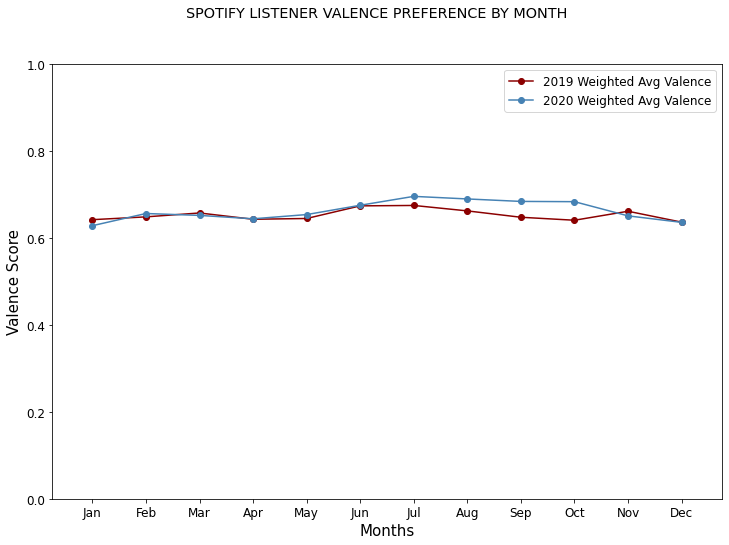

In [21]:
# Plot a comparison of 2019 2020 valence scores

# Set up lists to plot

valence_2019 = country_tracks_data_groupby[country_tracks_data_groupby['Year'] == 2019]

valence_2020 = country_tracks_data_groupby[country_tracks_data_groupby['Year'] == 2020]
valence_2020.drop('Year', inplace=True, axis=1)

fig= plt.figure(figsize=(12,8))                                      # Set up figure size
fig.suptitle('SPOTIFY LISTENER VALENCE PREFERENCE BY MONTH (USA)')         # Set up main title

y_axis = valence_2019['Valence_Stream%']
x_axis = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',                  # Set up x axis
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.plot(x_axis, valence_2019['Valence_Stream%'], label="2019 Weighted Avg Valence", marker='o', color='darkred')  # Plot 2019
plt.plot(x_axis, valence_2020['Valence_Stream%'], label="2020 Weighted Avg Valence", marker='o', color='steelblue')  # Plot 2020

plt.xlabel('Months')                                                 # Set up axis titles
plt.ylabel('Valence Score')

plt.xlim(-0.75, len(x_axis)-0.25)                                    # Set up axis limits
plt.ylim(0, 1)

plt.legend()                                                         # Include the legend

plt.show()


In [23]:
# Compare valence scores with covide infection rate

covid_df = pd.read_csv("input_files/owid-covid-data.csv")                # read the covid data file

country_covid_df = covid_df.loc[covid_df['location'] == 'Italy']   # Filter for country of your choice

country_covid_df.head()


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
37796,ITA,Europe,Italy,2020-01-31,2.0,2.0,NaN,NaN,NaN,NaN,...,35220.084,2.0,113.151,4.78,19.8,27.8,NaN,3.18,83.51,0.892
37797,ITA,Europe,Italy,2020-02-01,2.0,0.0,NaN,NaN,NaN,NaN,...,35220.084,2.0,113.151,4.78,19.8,27.8,NaN,3.18,83.51,0.892
37798,ITA,Europe,Italy,2020-02-02,2.0,0.0,NaN,NaN,NaN,NaN,...,35220.084,2.0,113.151,4.78,19.8,27.8,NaN,3.18,83.51,0.892
37799,ITA,Europe,Italy,2020-02-03,2.0,0.0,NaN,NaN,NaN,NaN,...,35220.084,2.0,113.151,4.78,19.8,27.8,NaN,3.18,83.51,0.892
37800,ITA,Europe,Italy,2020-02-04,2.0,0.0,NaN,NaN,NaN,NaN,...,35220.084,2.0,113.151,4.78,19.8,27.8,NaN,3.18,83.51,0.892


In [24]:
# Filter data for 2020, and add a 'month' column

country_covid__2020_df = country_covid_df[country_covid_df.date.str.contains(r'2020.*')]

country_covid__2020_df['Month'] = ''
country_covid__2020_df.head()

<ipython-input-24-9a7ab2cb5104>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_covid__2020_df['Month'] = ''


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,Month
37796,ITA,Europe,Italy,2020-01-31,2.0,2.0,NaN,NaN,NaN,NaN,...,2.0,113.151,4.78,19.8,27.8,NaN,3.18,83.51,0.892,
37797,ITA,Europe,Italy,2020-02-01,2.0,0.0,NaN,NaN,NaN,NaN,...,2.0,113.151,4.78,19.8,27.8,NaN,3.18,83.51,0.892,
37798,ITA,Europe,Italy,2020-02-02,2.0,0.0,NaN,NaN,NaN,NaN,...,2.0,113.151,4.78,19.8,27.8,NaN,3.18,83.51,0.892,
37799,ITA,Europe,Italy,2020-02-03,2.0,0.0,NaN,NaN,NaN,NaN,...,2.0,113.151,4.78,19.8,27.8,NaN,3.18,83.51,0.892,
37800,ITA,Europe,Italy,2020-02-04,2.0,0.0,NaN,NaN,NaN,NaN,...,2.0,113.151,4.78,19.8,27.8,NaN,3.18,83.51,0.892,


In [25]:
# Extract the month from the 'date' column and add it to the new 'month' column, for sorting later

for index, row in country_covid__2020_df.iterrows():
    month, = re.findall(f"2020-(\d\d)-", row['date'])
    country_covid__2020_df.at[index, 'Month'] = int(month)  

country_covid__2020_df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,Month
37796,ITA,Europe,Italy,2020-01-31,2.0,2.0,NaN,NaN,NaN,NaN,...,2.0,113.151,4.78,19.8,27.8,NaN,3.18,83.51,0.892,1
37797,ITA,Europe,Italy,2020-02-01,2.0,0.0,NaN,NaN,NaN,NaN,...,2.0,113.151,4.78,19.8,27.8,NaN,3.18,83.51,0.892,2
37798,ITA,Europe,Italy,2020-02-02,2.0,0.0,NaN,NaN,NaN,NaN,...,2.0,113.151,4.78,19.8,27.8,NaN,3.18,83.51,0.892,2
37799,ITA,Europe,Italy,2020-02-03,2.0,0.0,NaN,NaN,NaN,NaN,...,2.0,113.151,4.78,19.8,27.8,NaN,3.18,83.51,0.892,2
37800,ITA,Europe,Italy,2020-02-04,2.0,0.0,NaN,NaN,NaN,NaN,...,2.0,113.151,4.78,19.8,27.8,NaN,3.18,83.51,0.892,2


In [50]:
# Create a groupby to get the sum of new cases in each month

country_covid__2020_groupby = country_covid__2020_df.groupby(['Month'], as_index=False)['new_cases'].sum()
country_covid__2020_groupby


,Month,new_cases
0,1,2.0
1,2,1126.0
2,3,104664.0
3,4,99671.0
4,5,27534.0
5,6,7581.0
6,7,6959.0
7,8,21677.0
8,9,45647.0
9,10,364569.0


In [51]:
# TIP: This next section is to add missing months. In the case of New Zealand, there was no data for January
# For other countries, it might vary. Here's how I added January to the dataframe:

# No need to add january in Italy
# country_covid__2020_groupby.loc[-1] = [1, 0]             # This adds a 1 (month of January) in the first columne 
                                                         # index 0), in the last row of the dataframe. 

# country_covid__2020_groupby.index = country_covid__2020_groupby.index + 1   # shifts the index
country_covid__2020_groupby = country_covid__2020_groupby.sort_index()      # sorts by index

country_covid__2020_groupby = country_covid__2020_groupby.rename(columns={"new_cases": "New Cases"})

country_covid__2020_groupby


,Month,New Cases
0,1,2.0
1,2,1126.0
2,3,104664.0
3,4,99671.0
4,5,27534.0
5,6,7581.0
6,7,6959.0
7,8,21677.0
8,9,45647.0
9,10,364569.0


In [52]:
# Merge the dataframes into one nice comparison dataframe to scatter plot

country_covid_valence_df = pd.merge(valence_2020, country_covid__2020_groupby, on="Month")

country_covid_valence_df

,Month,Valence_Stream%,New Cases
0,1,0.628000,2.0
1,2,0.656018,1126.0
2,3,0.651668,104664.0
3,4,0.643867,99671.0
4,5,0.653568,27534.0
5,6,0.675014,7581.0
6,7,0.695445,6959.0
7,8,0.689500,21677.0
8,9,0.683833,45647.0
9,10,0.683220,364569.0


In [53]:
# Add a new cases per million column

country_polulation = 5002100  #TIP: This the population of New Zealand. Adjust for your country

country_covid_valence_df['New Cases Per Million'] = country_covid_valence_df['New Cases'] / country_polulation *1000000

country_covid_valence_df

,Month,Valence_Stream%,New Cases,New Cases Per Million
0,1,0.628000,2.0,0.399832
1,2,0.656018,1126.0,225.105456
2,3,0.651668,104664.0,20924.011915
3,4,0.643867,99671.0,19925.831151
4,5,0.653568,27534.0,5504.488115
5,6,0.675014,7581.0,1515.563463
6,7,0.695445,6959.0,1391.215689
7,8,0.689500,21677.0,4333.579896
8,9,0.683833,45647.0,9125.567262
9,10,0.683220,364569.0,72883.189061


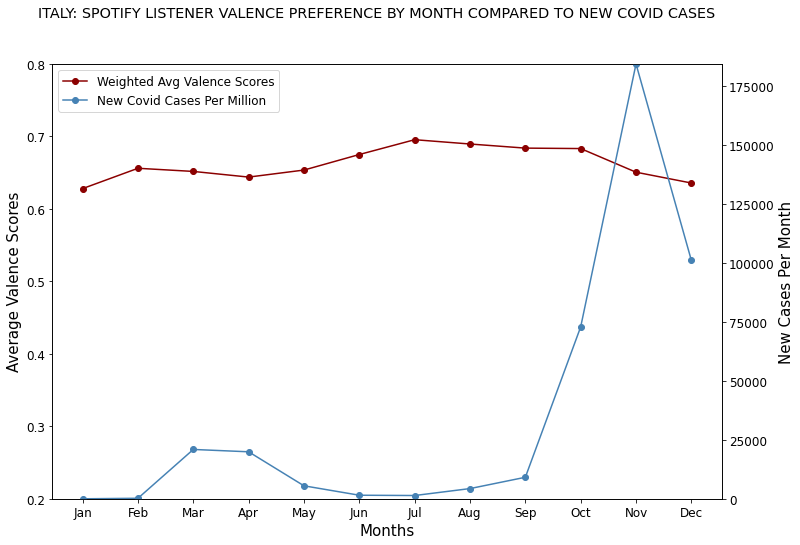

In [54]:
# Line plot relationship between Valence scores and New Cases per Million with shared x axis and duel y axes

fig, ax1 = plt.subplots(figsize=(12,8))                   # Set up subplot figure and size
fig.suptitle('USA: SPOTIFY LISTENER VALENCE PREFERENCE BY MONTH COMPARED TO NEW COVID CASES')

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',       # Set up shared x axis
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

ax1.set_xlabel('Months')                

ax1.set_ylabel('Average Valence Scores')                  # Set up first plot 
ax1.set_ylim([.2, .8])

ax1_ydata = country_covid_valence_df['Valence_Stream%']
ax1.plot(months, ax1_ydata, label="Weighted Avg Valence Scores", marker='o', color='darkred')                       
                        
ax2 = ax1.twinx()                                         # Set up second plot 
ax2.set_ylabel('New Cases Per Month')
ax2_ydata = country_covid_valence_df['New Cases Per Million']
ax2.set_ylim([0, ax2_ydata.max()+20])
ax2.plot(months, ax2_ydata, label="New Covid Cases Per Million", marker='o', color='steelblue')


lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

plt.show()

In [55]:
# This is a mini function that adds a qualitative label to the correlation r score in the scatter plot

def r_label(r):
    abs_r = abs(r)
    if abs_r >= .8 : return "Very Strong"
    elif abs_r >= .6 : return "Strong"
    elif abs_r >= .4: return "Moderate"
    elif abs_r >= .2: return "Low"
    else: return "Negligible"

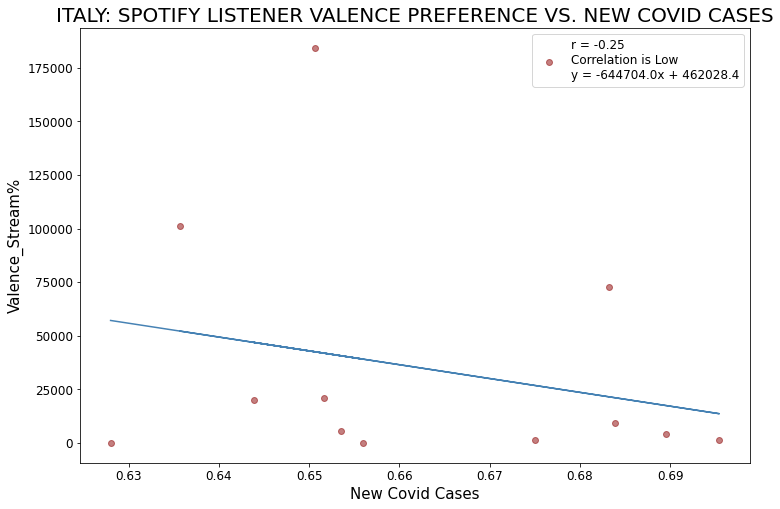

In [56]:
# Line plot relationship between Valence scores and New Cases per Million with shared x axis and duel y axes

x_axis = country_covid_valence_df['Valence_Stream%']                                 # Set up axes
y_axis = country_covid_valence_df['New Cases Per Million']

slope, intercept, rvalue, pvalue, stderr = stats.linregress(x_axis, y_axis)  # Get elements of regression equation
regress_values = x_axis * slope + intercept                                  # Calculate regression values

plt.figure(figsize=(12, 8))
plt.title('ITALY: SPOTIFY LISTENER VALENCE PREFERENCE VS. NEW COVID CASES') # CHANGE TITLE TO REFLECT YOUR COUNTRY

plt.xlabel(f"New Covid Cases")                                               # Set x axis label for subplot                  
plt.ylabel(f"Valence_Stream%")                                                       # Set title for subplot

r = round(stats.pearsonr(x_axis, y_axis)[0],2)                       # Calculate correlation coefficient
rlabel = r_label(r)                                                 # Call function to create a label for the r number

line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))    # Ression formula

plt.scatter(x_axis, y_axis, facecolors="darkred",  alpha=.5,        # Plot the scatter chart
label=f"r = {r}\nCorrelation is {rlabel}\n{line_eq}" ) 

plt.plot(x_axis, regress_values, color="steelblue")                 # Plot the regression line    

plt.legend()                                                        # Add the legend
    
plt.savefig("output_files/valence_vs_newcases.png")                 # Save the png file   

plt.show()